In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from pathlib import Path
from scipy.stats import f_oneway

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler ,OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer


from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm
import optuna

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Importando os dados

In [140]:
df = pd.read_csv('./data/desafio_indicium_imdb.csv', index_col=0)
df.head(3)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"


In [141]:
df.describe()

,IMDB_Rating,Meta_score,No_of_Votes
count,999.000000,842.000000,9.990000e+02
mean,7.947948,77.969121,2.716214e+05
std,0.272290,12.383257,3.209126e+05
min,7.600000,28.000000,2.508800e+04
25%,7.700000,70.000000,5.547150e+04
50%,7.900000,79.000000,1.383560e+05
75%,8.100000,87.000000,3.731675e+05
max,9.200000,100.000000,2.303232e+06


In [142]:
# Dicionário com os dados fornecidos
data = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'IMDB_Rating': 7.947948, #necessario colocar para nao quebrar o código na hora da predição
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}

# criar DataFrame da nova linha
df4 = pd.DataFrame([data])

# definir índice para não sobrescrever o existente
next_idx = (df.index.max() + 1) if len(df) > 0 else 1
df4.index = [next_idx]

# concatenar ao df original (alinha colunas automaticamente)
df = pd.concat([df, df4], sort=False)

print(f'Linha adicionada com índice {next_idx}. Novo tamanho do df: {df.shape}')
df.tail(1)

# # Criando o DataFrame com apenas uma linha
# df4 = pd.DataFrame([data])

# df4.head()

# # Criando o DataFrame com apenas uma linha
# df4 = pd.DataFrame([data])

# df4.head()

Linha adicionada com índice 1000. Novo tamanho do df: (1000, 15)


,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1000,The Shawshank Redemption,1994,A,142 min,Drama,7.947948,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"


# Primeiras Analises

In [143]:
print(f'Dimensões do dataframe')
print(f'Número de amostras: {df.shape[0]} \nNúmero de features: {df.shape[1]}')

Dimensões do dataframe
Número de amostras: 1000 
Número de features: 15


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   1000 non-null   object 
 1   Released_Year  1000 non-null   object 
 2   Certificate    899 non-null    object 
 3   Runtime        1000 non-null   object 
 4   Genre          1000 non-null   object 
 5   IMDB_Rating    1000 non-null   float64
 6   Overview       1000 non-null   object 
 7   Meta_score     843 non-null    float64
 8   Director       1000 non-null   object 
 9   Star1          1000 non-null   object 
 10  Star2          1000 non-null   object 
 11  Star3          1000 non-null   object 
 12  Star4          1000 non-null   object 
 13  No_of_Votes    1000 non-null   int64  
 14  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(12)
memory usage: 125.0+ KB


In [145]:
df.describe()

,IMDB_Rating,Meta_score,No_of_Votes
count,1000.000000,843.000000,1.000000e+03
mean,7.947948,77.971530,2.736929e+05
std,0.272153,12.376099,3.273727e+05
min,7.600000,28.000000,2.508800e+04
25%,7.700000,70.000000,5.552625e+04
50%,7.900000,79.000000,1.385485e+05
75%,8.100000,87.000000,3.741612e+05
max,9.200000,100.000000,2.343110e+06


Analizando a variavel *Genre* e *Overview* .

In [146]:
df['Genre'].nunique()

202

In [147]:
# Distribuição percentual dos gêneros
aux = df['Genre'].value_counts()/df.shape[0] * 100
aux.head(10)


Genre
Drama                           8.5
Drama, Romance                  3.7
Comedy, Drama                   3.5
Comedy, Drama, Romance          3.1
Action, Crime, Drama            3.0
Biography, Drama, History       2.8
Crime, Drama, Thriller          2.8
Crime, Drama, Mystery           2.7
Crime, Drama                    2.6
Animation, Adventure, Comedy    2.4
Name: count, dtype: float64

In [148]:
# df.groupby('Genre').value_counts().sort_values(ascending=False).head(50)
print(f'Número de diretores únicos: {df["Director"].nunique()}')
df['Director'].value_counts().sort_values(ascending=False).head(10)

Número de diretores únicos: 548


Director
Alfred Hitchcock     14
Steven Spielberg     13
Hayao Miyazaki       11
Akira Kurosawa       10
Martin Scorsese      10
Woody Allen           9
Stanley Kubrick       9
Billy Wilder          9
Clint Eastwood        8
Christopher Nolan     8
Name: count, dtype: int64

In [149]:
df['Overview']

1       An organized crime dynasty's aging patriarch t...
2       When the menace known as the Joker wreaks havo...
3       The early life and career of Vito Corleone in ...
4       A jury holdout attempts to prevent a miscarria...
5       Gandalf and Aragorn lead the World of Men agai...
                              ...                        
996     Sprawling epic covering the life of a Texas ca...
997     In Hawaii in 1941, a private is cruelly punish...
998     Several survivors of a torpedoed merchant ship...
999     A man in London tries to help a counter-espion...
1000    Two imprisoned men bond over a number of years...
Name: Overview, Length: 1000, dtype: object

## Realizando Algumas Manipulações para Melhor Compreensão

As colunas Released_Year, Runtime, Gross sserão converidas para int e float.

In [150]:
df[['Released_Year','Runtime','Gross']].head()

,Released_Year,Runtime,Gross
1,1972,175 min,"134,966,411"
2,2008,152 min,"534,858,444"
3,1974,202 min,"57,300,000"
4,1957,96 min,"4,360,000"
5,2003,201 min,"377,845,905"


In [151]:
df['Released_Year'] = df['Released_Year'].replace('PG',1995).astype(int)
df.loc[df['Series_Title'] == "Apollo 13"]


,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
966,Apollo 13,1995,U,140 min,"Adventure, Drama, History",7.6,NASA must devise a strategy to return Apollo 1...,77.0,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,269197,"173,837,933"


In [152]:
# Corrigir Released_Year e types
df['Runtime'] = df['Runtime'].str.replace(' min', '', regex=False)
df['Gross'] = df['Gross'].str.replace('$','', regex=False).str.replace(',','', regex=False)
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')
df['Runtime'] = pd.to_numeric(df['Runtime'], errors='coerce')
df['Gross'] = pd.to_numeric(df['Gross'], errors='coerce')

In [153]:
df[['Released_Year','Runtime','Gross']].head()

,Released_Year,Runtime,Gross
1,1972,175,134966411.0
2,2008,152,534858444.0
3,1974,202,57300000.0
4,1957,96,4360000.0
5,2003,201,377845905.0


1. Extrair ano e década de Released_Year
2. Criar indicadores de sucesso, como:

 - Gross_per_Vote = Gross / No_of_Votes.

 - Runtime_Category (curto <90min, médio 90–120min, longo >120min).

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   1000 non-null   object 
 1   Released_Year  1000 non-null   int64  
 2   Certificate    899 non-null    object 
 3   Runtime        1000 non-null   int64  
 4   Genre          1000 non-null   object 
 5   IMDB_Rating    1000 non-null   float64
 6   Overview       1000 non-null   object 
 7   Meta_score     843 non-null    float64
 8   Director       1000 non-null   object 
 9   Star1          1000 non-null   object 
 10  Star2          1000 non-null   object 
 11  Star3          1000 non-null   object 
 12  Star4          1000 non-null   object 
 13  No_of_Votes    1000 non-null   int64  
 14  Gross          831 non-null    float64
dtypes: float64(3), int64(3), object(9)
memory usage: 125.0+ KB


In [155]:
df2 = df.copy()

In [156]:
df2['Decada'] = df2['Released_Year'].apply(lambda x: int((x // 10) * 10) if pd.notnull(x) else np.nan)
df2['Gross_por_Voto'] = df2['Gross'] / df2['No_of_Votes']
df2['Runtime_Category'] = pd.cut(df2['Runtime'], bins=[0, 90, 120, np.inf], labels=['curto', 'médio', 'longo']) # Runtime_Category (curto <90min, médio 90–120min, longo >120min).
df2['MetaScore_decada'] = df2['Meta_score'] / df2['Decada']

In [157]:
df2[['Released_Year', 'Decada', 'Gross_por_Voto', 'Runtime_Category']].head()

,Released_Year,Decada,Gross_por_Voto,Runtime_Category
1,1972,1970,83.293730,longo
2,2008,2000,232.220829,longo
3,1974,1970,50.710119,longo
4,1957,1950,6.320260,médio
5,2003,2000,230.007040,longo


In [158]:
df2['Decada'].value_counts().sort_index()

Decada
1920     11
1930     24
1940     35
1950     56
1960     73
1970     76
1980     89
1990    151
2000    237
2010    242
2020      6
Name: count, dtype: int64

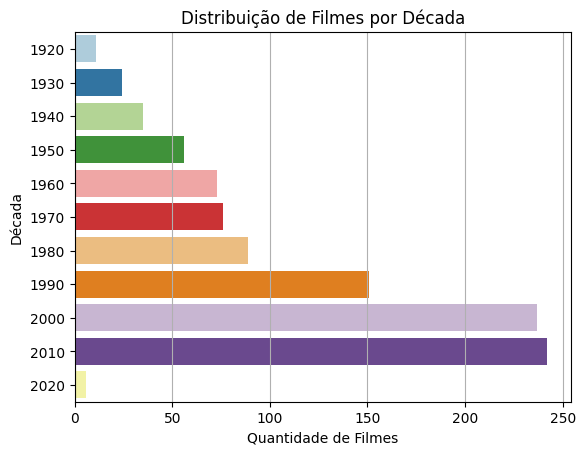

In [159]:
# barras horizontais por década
counts = df2['Decada'].value_counts().sort_index()
sns.barplot(x=counts.values, y=counts.index, palette="Paired", orient='h')
# plt.xticks(rotation=90)
plt.grid(axis='x')
plt.xlabel('Quantidade de Filmes')
plt.ylabel('Década')
plt.title('Distribuição de Filmes por Década')
plt.show()


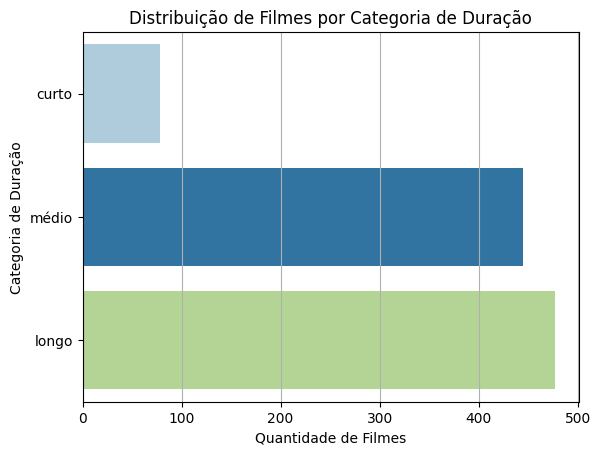

In [160]:
counts = df2['Runtime_Category'].value_counts().sort_index()
sns.barplot(x=counts.values, y=counts.index, palette="Paired", orient='h')
# plt.xticks(rotation=90)
plt.grid(axis='x')
plt.xlabel('Quantidade de Filmes')
plt.ylabel('Categoria de Duração')
plt.title('Distribuição de Filmes por Categoria de Duração')
plt.show()

Verificando se as Features possue dados não preencidos. 

In [161]:
def verifica_nulos(df):
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            # print(f'Existem valores ausentes na coluna {col}')
            n = df[col].isnull().sum()
            porcent = (n / df.shape[0]) * 100
            print(f'Número de valores ausentes em {col}: {n} \nPorcentagem de valores ausentes: {porcent:.2f}%')
            print('===========================================================')
        # else:
        #     pass
        #     # print(f'Não existem valores ausentes na coluna {col}')


In [162]:
verifica_nulos(df2)


Número de valores ausentes em Certificate: 101 
Porcentagem de valores ausentes: 10.10%
Número de valores ausentes em Meta_score: 157 
Porcentagem de valores ausentes: 15.70%
Número de valores ausentes em Gross: 169 
Porcentagem de valores ausentes: 16.90%
Número de valores ausentes em Gross_por_Voto: 169 
Porcentagem de valores ausentes: 16.90%
Número de valores ausentes em MetaScore_decada: 157 
Porcentagem de valores ausentes: 15.70%


# EDA Inicial

In [163]:
df_eda = df2.copy()
df_eda = df_eda.replace([''], np.nan)
df_eda.head(3)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Decada,Gross_por_Voto,Runtime_Category,MetaScore_decada
1,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,1970,83.293730,longo,0.050761
2,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0,2000,232.220829,longo,0.042000
3,The Godfather: Part II,1974,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0,1970,50.710119,longo,0.045685


In [164]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Series_Title      1000 non-null   object  
 1   Released_Year     1000 non-null   int64   
 2   Certificate       899 non-null    object  
 3   Runtime           1000 non-null   int64   
 4   Genre             1000 non-null   object  
 5   IMDB_Rating       1000 non-null   float64 
 6   Overview          1000 non-null   object  
 7   Meta_score        843 non-null    float64 
 8   Director          1000 non-null   object  
 9   Star1             1000 non-null   object  
 10  Star2             1000 non-null   object  
 11  Star3             1000 non-null   object  
 12  Star4             1000 non-null   object  
 13  No_of_Votes       1000 non-null   int64   
 14  Gross             831 non-null    float64 
 15  Decada            1000 non-null   int64   
 16  Gross_por_Voto    831 non-nul

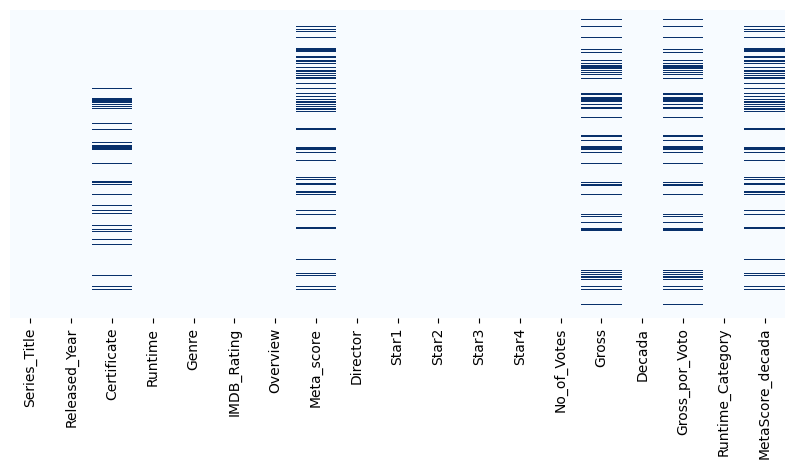

In [165]:
plt.figure(figsize=(10, 4))

sns.heatmap(df_eda.isnull(), cbar=False, cmap='Blues', yticklabels=False)
plt.show()

In [166]:
verifica_nulos(df_eda)

Número de valores ausentes em Certificate: 101 
Porcentagem de valores ausentes: 10.10%
Número de valores ausentes em Meta_score: 157 
Porcentagem de valores ausentes: 15.70%
Número de valores ausentes em Gross: 169 
Porcentagem de valores ausentes: 16.90%
Número de valores ausentes em Gross_por_Voto: 169 
Porcentagem de valores ausentes: 16.90%
Número de valores ausentes em MetaScore_decada: 157 
Porcentagem de valores ausentes: 15.70%


Primeiros Pontos de Atenção sobre o Dataset

_Características Numéricas:_

Foi identificado um volume significativo de dados ausentes nas colunas numéricas. Isso exige uma análise criteriosa na etapa de pré-processamento para decidir a melhor abordagem, como:
- Imputação de valores (média, mediana, valores derivados, etc.).
- Uso de modelos específicos para estimar os valores ausentes.

_Características Categóricas:_

O cenário de dados ausentes também se repete nas colunas categóricas. Isso requer uma avaliação técnica cuidadosa para lidar com as inconsistências. Algumas abordagens possíveis incluem:
- Imputação de categorias (como a mais frequente ou uma categoria específica como "Desconhecido").
- Conversão das categorias em variáveis indicadoras (one-hot encoding) após o tratamento.


### Identificação das variáveis numéricas e categóricas do dataset

In [167]:
numerical_columns = df_eda.select_dtypes(include=['number']).columns # Identificando variáveis numéricas
categorical_columns = df_eda.select_dtypes(exclude=['number']).columns # Identificando variáveis categóricas (excluindo numéricas)

print("Variáveis Numéricas:")
print(numerical_columns)

print("\nVariáveis Categóricas:")
print(categorical_columns)

Variáveis Numéricas:
Index(['Released_Year', 'Runtime', 'IMDB_Rating', 'Meta_score', 'No_of_Votes',
       'Gross', 'Decada', 'Gross_por_Voto', 'MetaScore_decada'],
      dtype='object')

Variáveis Categóricas:
Index(['Series_Title', 'Certificate', 'Genre', 'Overview', 'Director', 'Star1',
       'Star2', 'Star3', 'Star4', 'Runtime_Category'],
      dtype='object')


### Análise nas características quantitativas

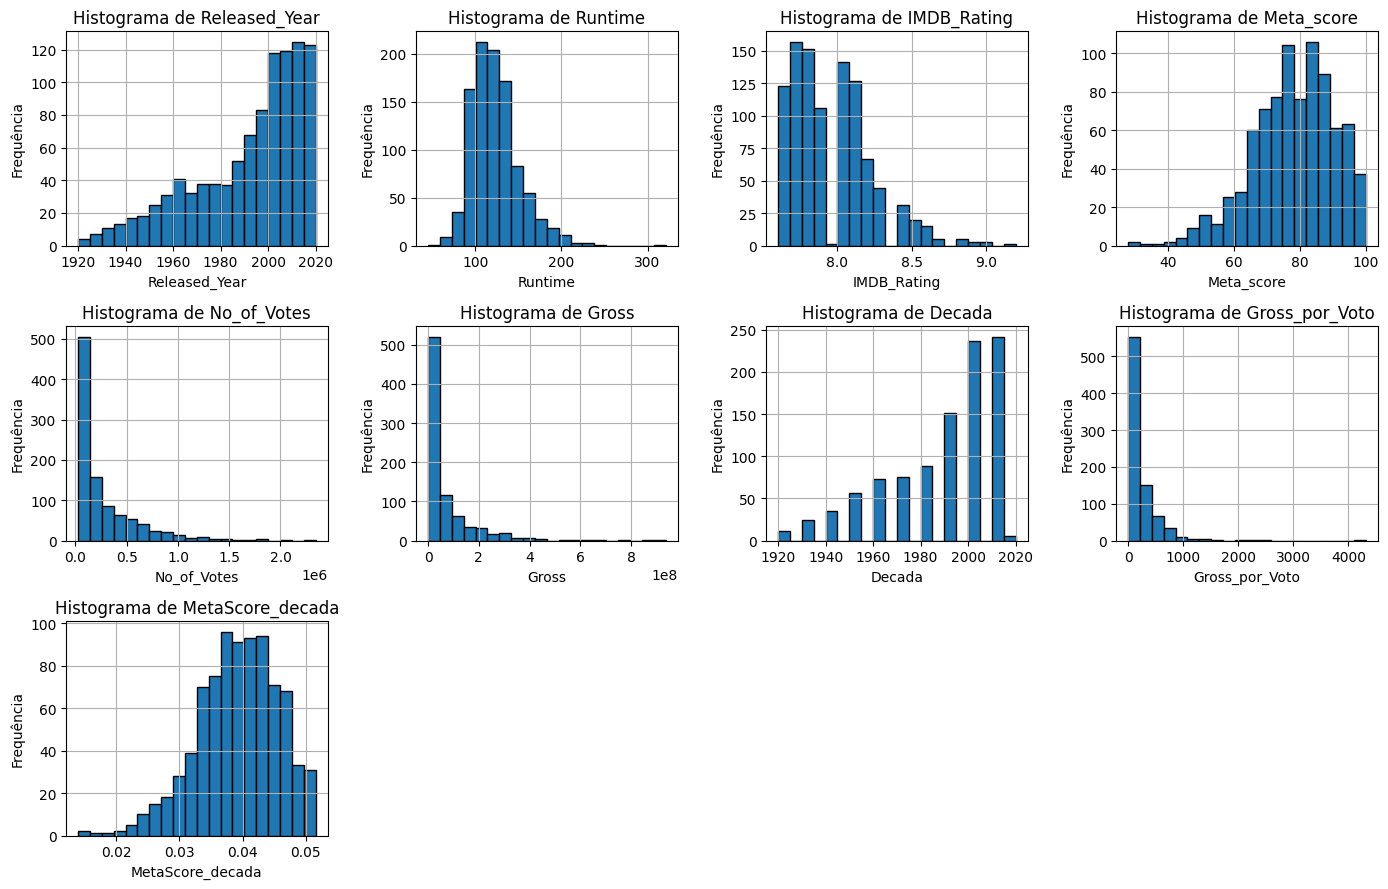

In [168]:
num_cols = len(numerical_columns)
num_rows = math.ceil(num_cols / 3)
plt.figure(figsize=(14, num_rows * 3))

# Criando os histogramas
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, 4, i)
    df_eda[column].hist(bins=20, edgecolor='black')
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

In [169]:
df_eda['Released_Year'].describe()

count    1000.000000
mean     1991.221000
std        23.285669
min      1920.000000
25%      1976.000000
50%      1999.000000
75%      2009.000000
max      2020.000000
Name: Released_Year, dtype: float64

In [170]:
df_eda['Released_Year'].value_counts().sort_index().head()

Released_Year
1920    1
1921    1
1922    1
1924    1
1925    2
Name: count, dtype: int64

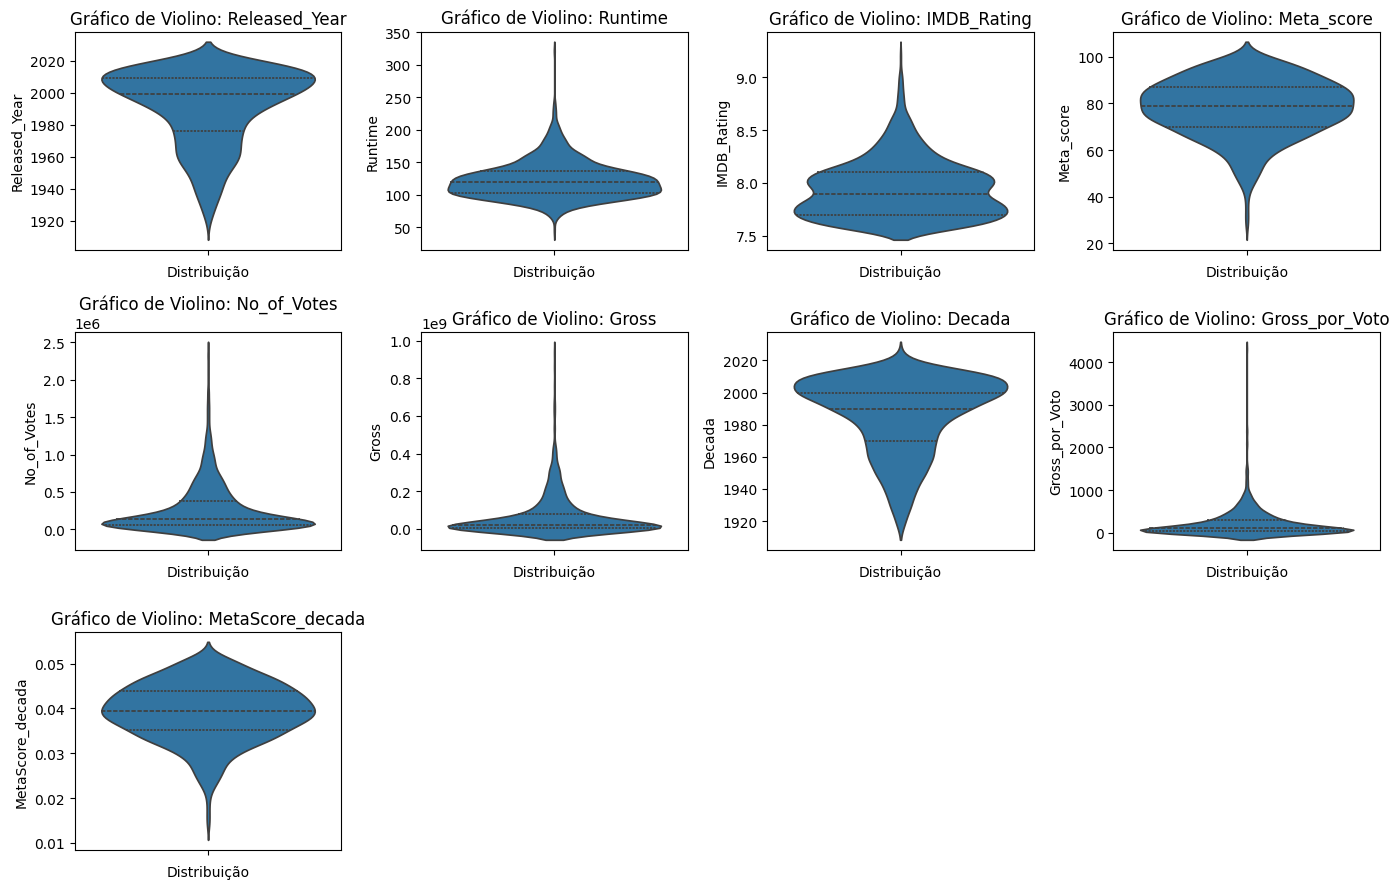

In [171]:
num_cols = len(numerical_columns)
num_rows = math.ceil(num_cols / 3)
plt.figure(figsize=(14, num_rows * 3))

# Criando os gráficos de violino
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, 4, i)
    sns.violinplot(data=df_eda, y=column, inner="quartile")
    plt.title(f'Gráfico de Violino: {column}')
    plt.xlabel('Distribuição')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

Pontos de Atenção para Algumas Variáveis

_Outliers nas Variáveis:_

`As variáveis Released_year e Gross em uma análise inicial, apresentam outliers que podem distorcer as análises. Caso realmente se confirmem como outliers, devem ser tratados de forma individualizada, considerando as características específicas de cada variável.`


_Estabilidade das Demais Variáveis:_

`As demais variáveis, em uma análise inicial, aparentam ser mais estáveis e não demandam intervenções imediatas, podendo ser analisadas em conjunto com os demais atributos no pipeline de pré-processamento.`

In [172]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Series_Title      1000 non-null   object  
 1   Released_Year     1000 non-null   int64   
 2   Certificate       899 non-null    object  
 3   Runtime           1000 non-null   int64   
 4   Genre             1000 non-null   object  
 5   IMDB_Rating       1000 non-null   float64 
 6   Overview          1000 non-null   object  
 7   Meta_score        843 non-null    float64 
 8   Director          1000 non-null   object  
 9   Star1             1000 non-null   object  
 10  Star2             1000 non-null   object  
 11  Star3             1000 non-null   object  
 12  Star4             1000 non-null   object  
 13  No_of_Votes       1000 non-null   int64   
 14  Gross             831 non-null    float64 
 15  Decada            1000 non-null   int64   
 16  Gross_por_Voto    831 non-nul

### Correlações - Quantitativas (numéricas)

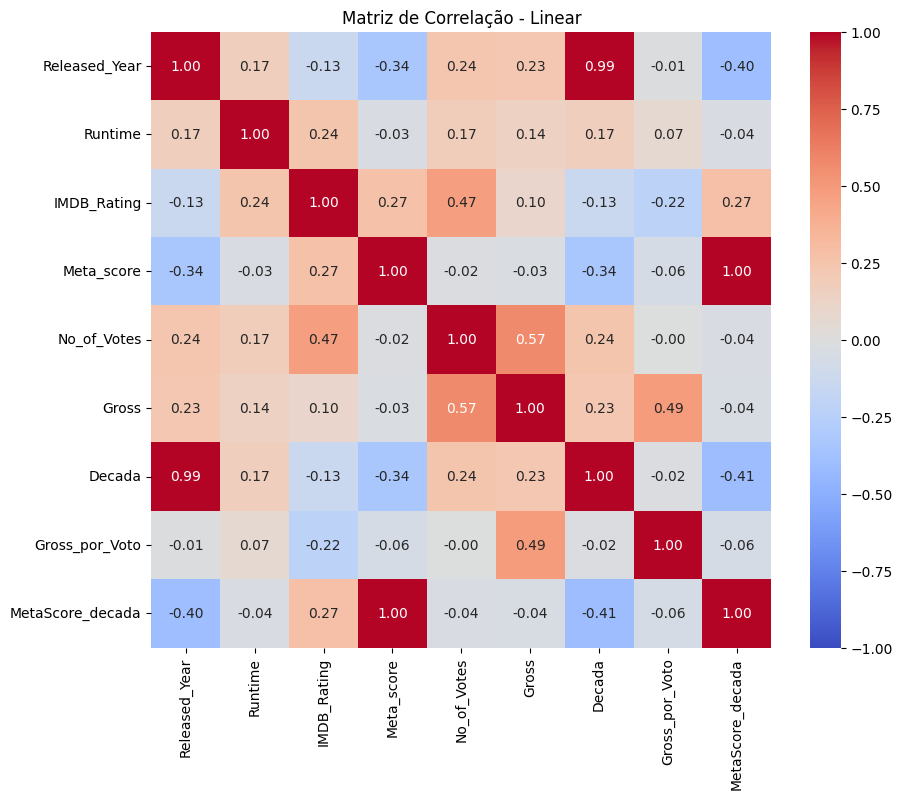

In [173]:
plt.figure(figsize=(10, 8))

correlation_matrix_pearson = df_eda.corr(method='pearson', numeric_only=True)
# mask = np.triu(np.ones_like(correlation_matrix_pearson, dtype=bool))
sns.heatmap(correlation_matrix_pearson,  annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1) #cbar=True,  mask=mask,

plt.title('Matriz de Correlação - Linear')
plt.show()


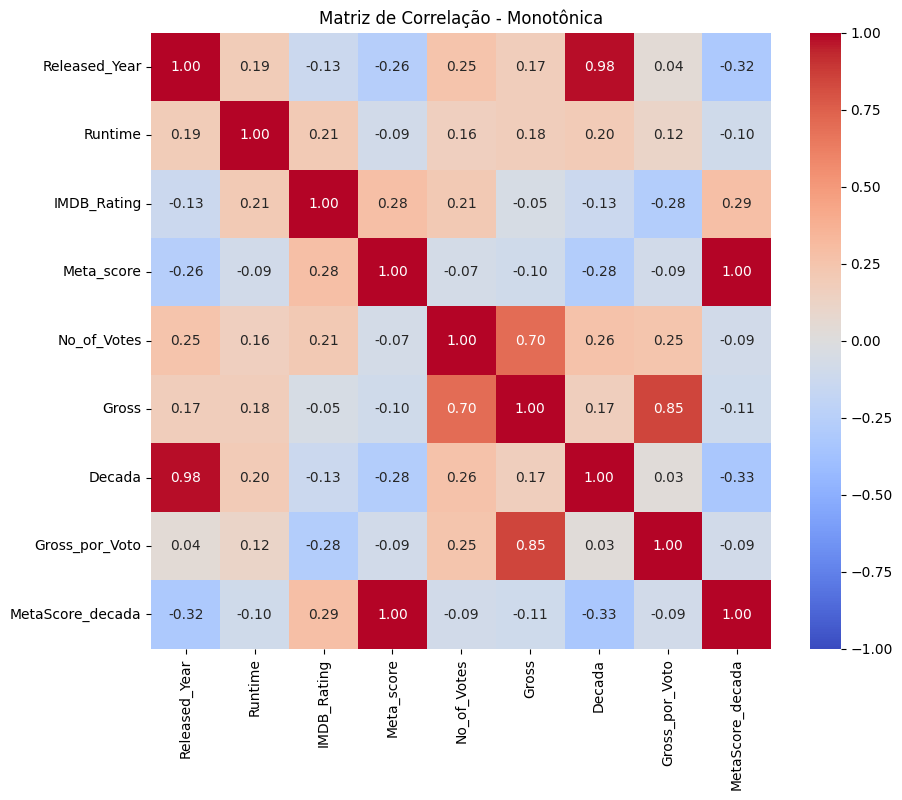

In [174]:
plt.figure(figsize=(10, 8))

correlation_matrix_spearman = df_eda.corr(method='spearman', numeric_only=True)
# mask = np.triu(np.ones_like(correlation_matrix_spearman, dtype=bool))
sns.heatmap(correlation_matrix_spearman,  annot=True, fmt='.2f', cmap='coolwarm', cbar=True, vmin=-1, vmax=1) #mask=mask,

plt.title('Matriz de Correlação - Monotônica')
plt.show()

Com base na análise de correlação quantitativa, observamos que apenas uma variável não apresenta uma relação relevante com a variável alvo IMDB_Rating. XXXXXX

### Aplicando transformação Logaritimica 

In [175]:
# como a calda esta para direita, usa-se a transformação logarítmica
# amostras_transform_log = df_eda.copy()
df_eda[['No_of_Votes', 'Runtime', 'Gross', 'Gross_por_Voto']] = df_eda[['No_of_Votes', 'Runtime', 'Gross', 'Gross_por_Voto']].apply(lambda x: np.log1p(x) if x.dtype != 'object' else x)
df_eda["MetaScore_sqrt"] = np.sqrt(df_eda["MetaScore_decada"])

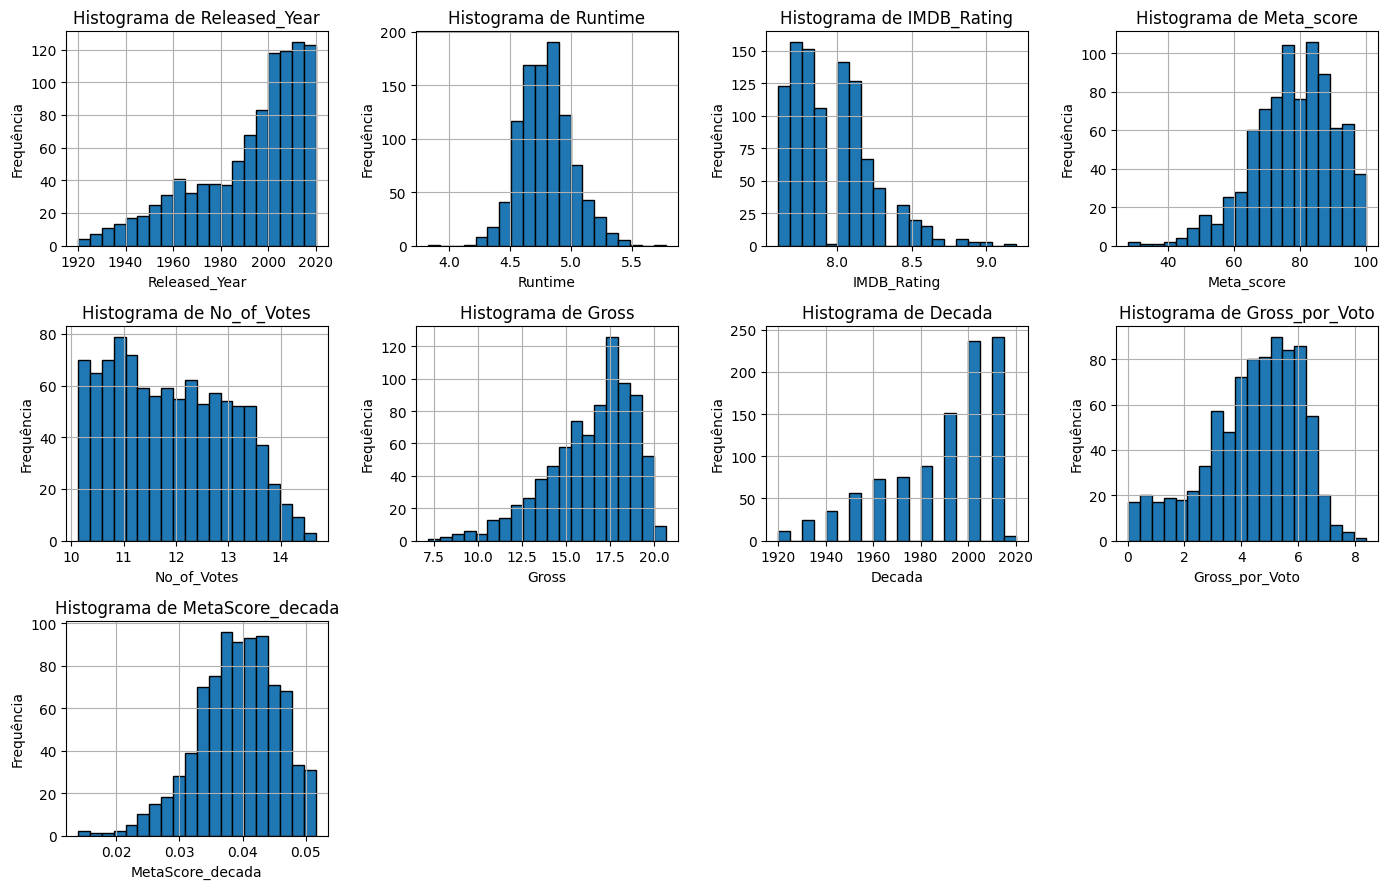

In [176]:
num_cols = len(numerical_columns)
num_rows = math.ceil(num_cols / 3)
plt.figure(figsize=(14, num_rows * 3))

# Criando os histogramas
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, 4, i)
    df_eda[column].hist(bins=20, edgecolor='black')
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

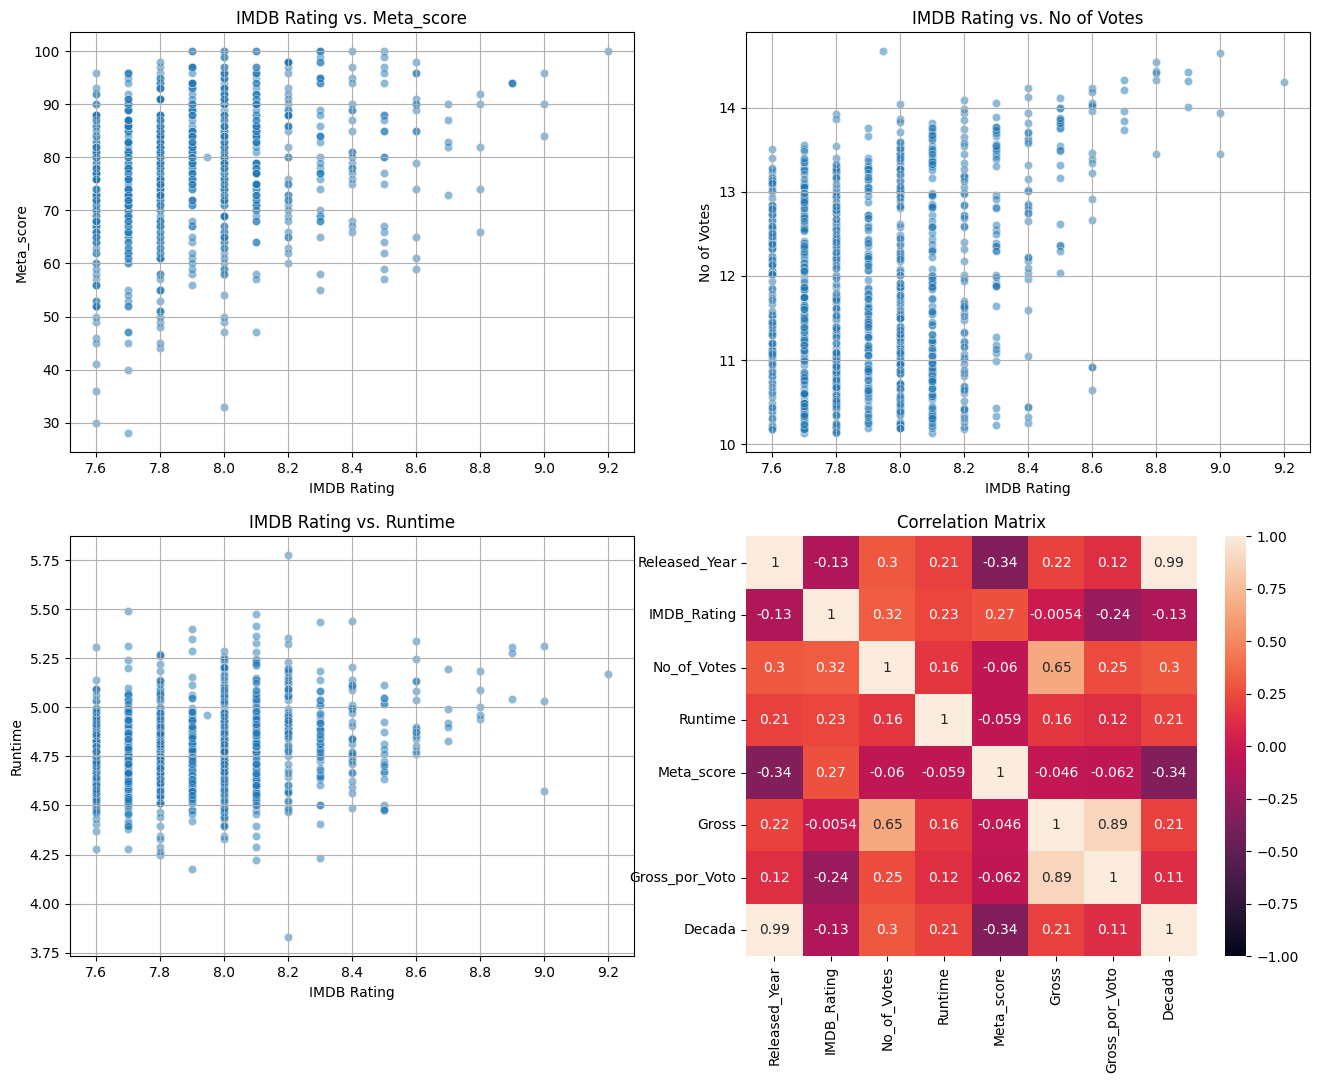

In [177]:
# Scatter plots and Correlation matrix

# Set up the figure and axis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Duration vs. Rating
sns.scatterplot(x=df_eda['IMDB_Rating'], y=df_eda['Meta_score'], alpha=0.5, ax=axes[0, 0])
axes[0, 0].set_title('IMDB Rating vs. Meta_score')
axes[0, 0].set_xlabel('IMDB Rating')
axes[0, 0].set_ylabel('Meta_score')
axes[0, 0].grid(True)

# Votes vs. Rating
sns.scatterplot(x=df_eda['IMDB_Rating'], y=df_eda['No_of_Votes'], alpha=0.5, ax=axes[0, 1])
axes[0, 1].set_title('IMDB Rating vs. No of Votes')
axes[0, 1].set_xlabel('IMDB Rating')
axes[0, 1].set_ylabel('No of Votes')
axes[0, 1].grid(True)

# Year vs. Rating
sns.scatterplot(x=df_eda['IMDB_Rating'], y=df_eda['Runtime'], alpha=0.5, ax=axes[1, 0])
axes[1, 0].set_title('IMDB Rating vs. Runtime')
axes[1, 0].set_xlabel('IMDB Rating')
axes[1, 0].set_ylabel('Runtime')
axes[1, 0].grid(True)

# Correlation matrix
numeric_features = df_eda[['Released_Year','IMDB_Rating', 'No_of_Votes', 'Runtime', 'Meta_score', 'Gross', 'Gross_por_Voto', 'Decada']]
correlation_matrix = numeric_features.corr(method='pearson', numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, vmin=-1, vmax=1, ax=axes[1, 1])
axes[1, 1].set_title('Correlation Matrix')

plt.show()


### Análise nas Caracteristicas Qualitativas

#### Certificate

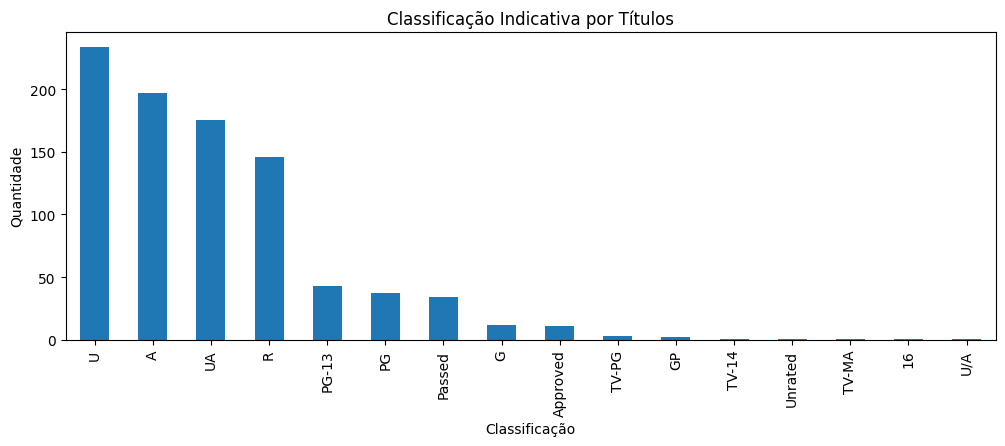

In [178]:
plt.figure(figsize=(12, 4))
df_eda['Certificate'].value_counts().plot(kind='bar')
plt.title('Classificação Indicativa por Títulos')
plt.xlabel('Classificação')
plt.ylabel('Quantidade')
plt.xticks(rotation=90)
plt.show()

In [179]:
# Mapeamento baseado em MPA (EUA) e CBFC (Índia)

mapa_cert = {
    # Livre / Universal
    'U': 'Livre',
    'G': 'Livre',
    'Approved': 'Livre',
    'Passed': 'Livre',

    # 10–13 (infantil/adolescente)
    'PG': '10-13',
    'PG-13': '10-13',
    'TV-PG': '10-13',
    'GP': '10-13',
    'UA': '10-13',
    'U/A': '10-13',

    # 14+ / Adulto
    'A': '14+',
    'R': '14+',
    'TV-14': '14+',
    '16': '14+',
    'TV-MA': '14+',

    # Sem classificação
    'Unrated': 'Sem classificação'
}

# Criar nova coluna com agrupamento
df_eda['Certificate_Group'] = df_eda['Certificate'].map(mapa_cert).fillna('Outro')

# Verificar resultado
print(df_eda['Certificate_Group'].value_counts())


Certificate_Group
14+                  346
Livre                291
10-13                261
Outro                101
Sem classificação      1
Name: count, dtype: int64


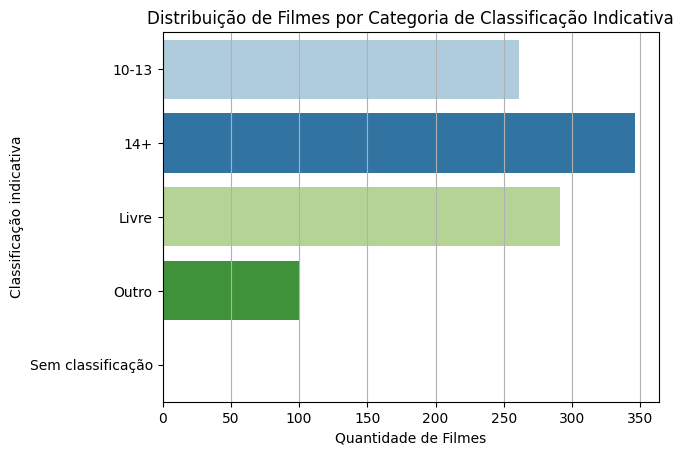

In [180]:
counts = df_eda['Certificate_Group'].value_counts().sort_index()
sns.barplot(x=counts.values, y=counts.index, palette="Paired", orient='h')
# plt.xticks(rotation=90)
plt.grid(axis='x')
plt.xlabel('Quantidade de Filmes')
plt.ylabel('Classificação indicativa')
plt.title('Distribuição de Filmes por Categoria de Classificação Indicativa')
plt.show()

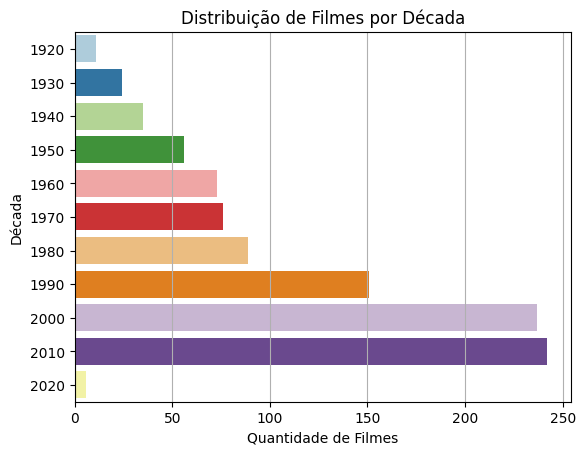

In [181]:
counts = df2['Decada'].value_counts().sort_index()
sns.barplot(x=counts.values, y=counts.index, palette="Paired", orient='h')
# plt.xticks(rotation=90)
plt.grid(axis='x')
plt.xlabel('Quantidade de Filmes')
plt.ylabel('Década')
plt.title('Distribuição de Filmes por Década')
plt.show()


In [182]:
df_eda['Year_balanced'] = df_eda['Decada'].apply(lambda x: '2000' if x in [2000, 2010, 2020] else '1900')
df_eda['Year_balanced'].value_counts()

Year_balanced
1900    515
2000    485
Name: count, dtype: int64

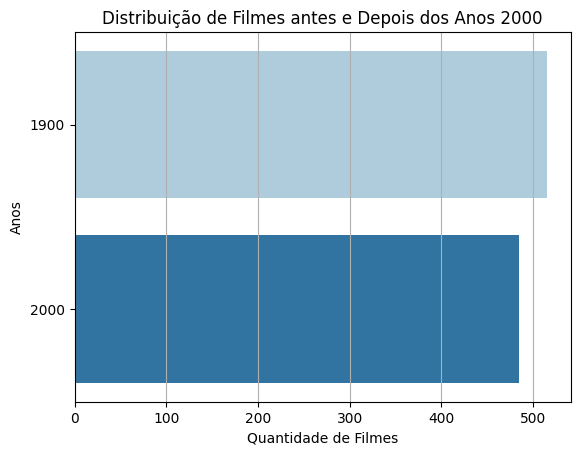

In [306]:
counts = df_eda['Year_balanced'].value_counts().sort_index()
sns.barplot(x=counts.values, y=counts.index, palette="Paired", orient='h')
# plt.xticks(rotation=90)
plt.grid(axis='x')
plt.xlabel('Quantidade de Filmes')
plt.ylabel('Anos')
plt.title('Distribuição de Filmes antes e Depois dos Anos 2000')
plt.show()

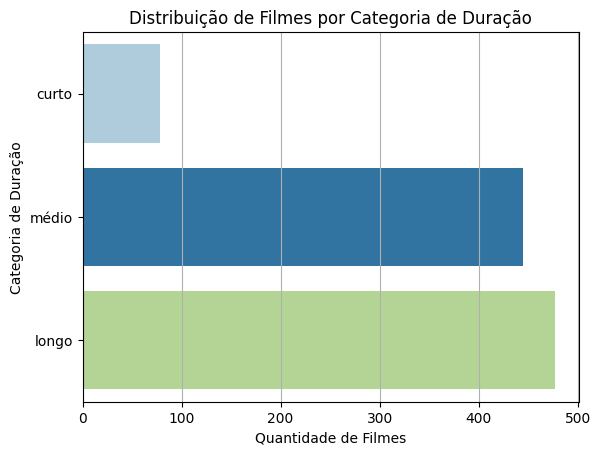

In [184]:
counts = df2['Runtime_Category'].value_counts().sort_index()
sns.barplot(x=counts.values, y=counts.index, palette="Paired", orient='h')
# plt.xticks(rotation=90)
plt.grid(axis='x')
plt.xlabel('Quantidade de Filmes')
plt.ylabel('Categoria de Duração')
plt.title('Distribuição de Filmes por Categoria de Duração')
plt.show()

O agrupamento foi baseado em sistemas de classificação oficiais: as diretrizes da MPA/CARA (G, PG, PG-13, R, NC-17) definem limites claros de idade e níveis de restrição, e o sistema da CBFC da Índia (U, UA, A com subdivisões como UA 7+, 13+, 16+) oferece rotações semelhantes, permitindo consolidar múltiplas variantes com baixa frequência em grupos robustos de interpretação e modelagem.

In [185]:
df_eda.columns

Index(['Series_Title', 'Released_Year', 'Certificate', 'Runtime', 'Genre',
       'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2',
       'Star3', 'Star4', 'No_of_Votes', 'Gross', 'Decada', 'Gross_por_Voto',
       'Runtime_Category', 'MetaScore_decada', 'MetaScore_sqrt',
       'Certificate_Group', 'Year_balanced'],
      dtype='object')

#### Genre

In [186]:
# Dicionário de agrupamento
genre_map = {
    'Drama': 'Drama',
    'Comedy': 'Comédia',
    'Action': 'Ação/Aventura',
    'Adventure': 'Ação/Aventura',
    'Crime': 'Crime/Thriller',
    'Thriller': 'Crime/Thriller',
    'Mystery': 'Crime/Thriller',
    'Film-Noir': 'Crime/Thriller',
    'Romance': 'Romance',
    'Fantasy': 'Fantasia/Ficção',
    'Sci-Fi': 'Fantasia/Ficção',
    'Horror': 'Terror',
    'Animation': 'Animação/Infantil',
    'Family': 'Animação/Infantil',
    'Biography': 'Histórico/Biografia',
    'History': 'Histórico/Biografia',
    'War': 'Histórico/Biografia',
    'Music': 'Música/Musical',
    'Musical': 'Música/Musical',
    'Western': 'Western'
}

# Função para mapear cada lista de gêneros
def map_genre(genre_str):
    for g in genre_map.keys():
        if g in genre_str:
            return genre_map[g]
    return 'Outros'

# Nova coluna com o agrupamento
df_eda['Genre_Group'] = df_eda['Genre'].apply(map_genre)

# Visualizar distribuição
print(df_eda['Genre_Group'].value_counts())


Genre_Group
Drama              724
Ação/Aventura      115
Comédia            110
Crime/Thriller      34
Fantasia/Ficção     11
Western              4
Terror               2
Name: count, dtype: int64


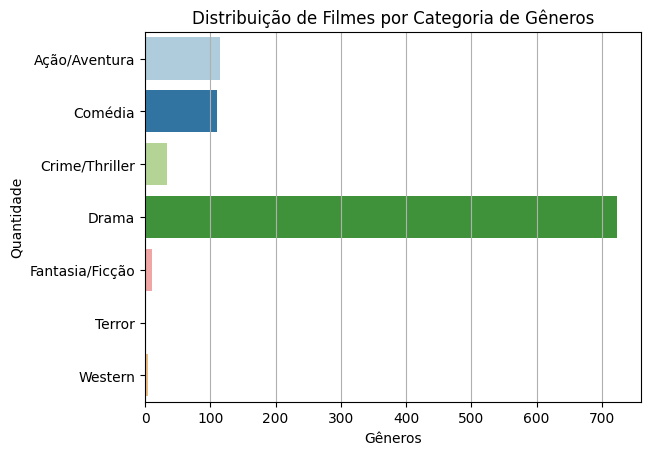

In [187]:
counts = df_eda['Genre_Group'].value_counts().sort_index()
sns.barplot(x=counts.values, y=counts.index, palette="Paired", orient='h')
# plt.xticks(rotation=90)
plt.grid(axis='x')
plt.xlabel('Gêneros')
plt.ylabel('Quantidade')
plt.title('Distribuição de Filmes por Categoria de Gêneros')
plt.show()


O resultado esperado foi a redução de centenas de combinações para ~10–12 categorias principais.

Mantém a essência narrativa do filme sem perder muita informação.

Um Problema identificado foi o desbalanceamento por parte da feature Drama.

In [188]:
df_eda['Genre_balanced'] = df_eda['Genre_Group'].apply(lambda x: x if x in 'Drama' else 'Other')
df_eda['Genre_balanced'].value_counts()

Genre_balanced
Drama    724
Other    276
Name: count, dtype: int64

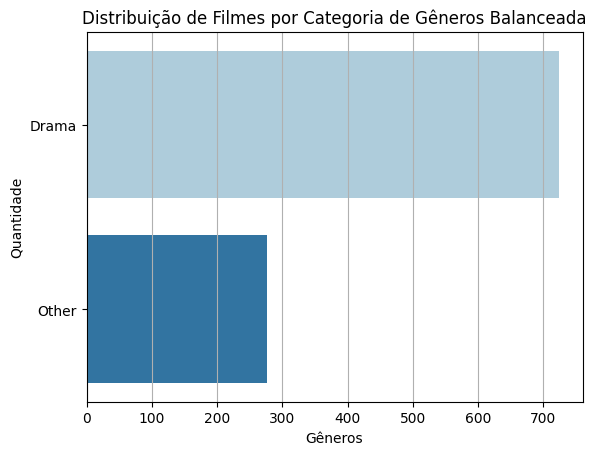

In [189]:
counts = df_eda['Genre_balanced'].value_counts().sort_index()
sns.barplot(x=counts.values, y=counts.index, palette="Paired", orient='h')
# plt.xticks(rotation=90)
plt.grid(axis='x')
plt.xlabel('Gêneros')
plt.ylabel('Quantidade')
plt.title('Distribuição de Filmes por Categoria de Gêneros Balanceada')
plt.show()

In [190]:
categorical_columns_to_dummy = categorical_columns
print(categorical_columns_to_dummy)

Index(['Series_Title', 'Certificate', 'Genre', 'Overview', 'Director', 'Star1',
       'Star2', 'Star3', 'Star4', 'Runtime_Category'],
      dtype='object')


In [191]:
print('Número de atores únicos (feature Star1):',df_eda['Star1'].nunique())
# df_eda['Star1'].value_counts().head(50) 

Número de atores únicos (feature Star1): 660


# Modelagem

In [270]:
df_model = df_eda.copy()
# df_model.head(1)

In [271]:
aux = df_model.tail(1).copy()
aux

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,...,Gross,Decada,Gross_por_Voto,Runtime_Category,MetaScore_decada,MetaScore_sqrt,Certificate_Group,Year_balanced,Genre_Group,Genre_balanced
1000,The Shawshank Redemption,1994,A,4.962845,Drama,7.947948,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,...,17.159837,1990,2.572281,longo,0.040201,0.200502,14+,1900,Drama,Drama


In [272]:
df_model.drop(index=1000, inplace=True)
df_model.tail(1)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,...,Gross,Decada,Gross_por_Voto,Runtime_Category,MetaScore_decada,MetaScore_sqrt,Certificate_Group,Year_balanced,Genre_Group,Genre_balanced
999,The 39 Steps,1935,NaN,4.465908,"Crime, Mystery, Thriller",7.6,A man in London tries to help a counter-espion...,93.0,Alfred Hitchcock,Robert Donat,...,NaN,1930,NaN,curto,0.048187,0.219514,Outro,1900,Crime/Thriller,Other


In [273]:
X = df_model.drop(columns=['IMDB_Rating'])#.drop(columns=['Released_Year','Certificate','Runtime','Meta_score','Gross','Series_Title','Overview', 'Genre', 'Director', 'Star1', 'Star2', 'Star3', 'Star4']) #'Certificate','Genre',
# X = df[['Runtime', 'Meta_score', 'No_of_Votes']]
y = df_model['IMDB_Rating']

X_aux = aux.drop(columns=['IMDB_Rating'])
y_aux = aux['IMDB_Rating']

In [274]:
print(y_aux)
X_aux

1000    7.947948
Name: IMDB_Rating, dtype: float64


,Series_Title,Released_Year,Certificate,Runtime,Genre,Overview,Meta_score,Director,Star1,Star2,...,Gross,Decada,Gross_por_Voto,Runtime_Category,MetaScore_decada,MetaScore_sqrt,Certificate_Group,Year_balanced,Genre_Group,Genre_balanced
1000,The Shawshank Redemption,1994,A,4.962845,Drama,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,...,17.159837,1990,2.572281,longo,0.040201,0.200502,14+,1900,Drama,Drama


In [275]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [276]:
# # adicionar X_aux ao final de X_test (e y_aux em y_test para manter consistência)
# X_aux = X_aux.reindex(columns=X_test.columns)  # garantir mesma ordem de colunas
# X_test = pd.concat([X_test, X_aux])
# y_test = pd.concat([y_test, y_aux])

# print("Shapes após append ->", "X_test:", X_test.shape, "y_test:", y_test.shape)
# X_test.tail(1)

In [277]:
# # Mover a amostra de índice 1000 de X_train para X_test (e y correspondente)
# idx = 1000

# if idx in X_train.index:
#     # extrair linha e target
#     X_row = X_train.loc[[idx]]
#     y_row = y_train.loc[[idx]]

#     # adicionar em X_test / y_test
#     X_test = pd.concat([X_test, X_row])
#     y_test = pd.concat([y_test, y_row])

#     # remover de X_train / y_train
#     X_train = X_train.drop(index=idx)
#     y_train = y_train.drop(index=idx)

#     print(f"Índice {idx} movido de X_train -> X_test")
# else:
#     print(f"Índice {idx} não encontrado em X_train (talvez já esteja em X_test).")

# print("Shapes após a operação:")
# print("X_train:", X_train.shape, "X_test:", X_test.shape)
# print("y_train:", y_train.shape, "y_test:", y_test.shape)

# # # Reajustar o pipeline no novo X_train e transformar ambos os conjuntos
# # X_train_transformed = pipeline.fit_transform(X_train)
# # X_test_transformed = pipeline.transform(X_test)

# # Mostrar a linha movida em X_test para verificação
# X_test.loc[[idx]]

In [278]:
# Mostrando os conjuntos
print("X_train:\n", X_train.shape)
print("\nX_test:\n", X_test.shape)
print("\ny_train:\n", y_train.shape)
print("\ny_test:\n", y_test.shape)

X_train:
 (699, 23)

X_test:
 (300, 23)

y_train:
 (699,)

y_test:
 (300,)


## Pré-processamento

In [279]:
X_train.isnull().sum()

Series_Title           0
Released_Year          0
Certificate           66
Runtime                0
Genre                  0
Overview               0
Meta_score            99
Director               0
Star1                  0
Star2                  0
Star3                  0
Star4                  0
No_of_Votes            0
Gross                115
Decada                 0
Gross_por_Voto       115
Runtime_Category       0
MetaScore_decada      99
MetaScore_sqrt        99
Certificate_Group      0
Year_balanced          0
Genre_Group            0
Genre_balanced         0
dtype: int64

In [280]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 699 entries, 729 to 103
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Series_Title       699 non-null    object  
 1   Released_Year      699 non-null    int64   
 2   Certificate        633 non-null    object  
 3   Runtime            699 non-null    float64 
 4   Genre              699 non-null    object  
 5   Overview           699 non-null    object  
 6   Meta_score         600 non-null    float64 
 7   Director           699 non-null    object  
 8   Star1              699 non-null    object  
 9   Star2              699 non-null    object  
 10  Star3              699 non-null    object  
 11  Star4              699 non-null    object  
 12  No_of_Votes        699 non-null    float64 
 13  Gross              584 non-null    float64 
 14  Decada             699 non-null    int64   
 15  Gross_por_Voto     584 non-null    float64 
 16  Runtime_Cat

#### Pipeline

In [281]:
df_model.select_dtypes(exclude=['number']).columns

Index(['Series_Title', 'Certificate', 'Genre', 'Overview', 'Director', 'Star1',
       'Star2', 'Star3', 'Star4', 'Runtime_Category', 'Certificate_Group',
       'Year_balanced', 'Genre_Group', 'Genre_balanced'],
      dtype='object')

In [282]:
df_model.select_dtypes(include=['number']).columns

Index(['Released_Year', 'Runtime', 'IMDB_Rating', 'Meta_score', 'No_of_Votes',
       'Gross', 'Decada', 'Gross_por_Voto', 'MetaScore_decada',
       'MetaScore_sqrt'],
      dtype='object')

In [283]:
# Listar recursos categóricos e numéricos
numeric_features = df_model.select_dtypes(include=['number']).columns # Identificando variáveis numéricas
numeric_features = numeric_features.drop(['IMDB_Rating','Released_Year', 'Runtime','Meta_score','Gross',]) # Removendo a variável alvo 'IMDB_Rating'
categorical_features = df_model.select_dtypes(exclude=['number']).columns # Identificando variáveis categóricas (excluindo numéricas)
categorical_features = categorical_features.drop(['Series_Title', 'Certificate', 'Genre', 'Overview',  'Star1',
       'Star2', 'Star3', 'Star4', 'Genre_Group', 'Year_balanced']) #'Director', 

# Etapas de pré-processamento para dados numéricos
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Preenchimento com a mediana
    # ('imputer', KNNImputer(n_neighbors=5, weights='uniform')),  # Preenchimento com KNNImputer
    ('scaler', StandardScaler())  # Escala Standard - StandardScaler - MinMaxScaler
])

# Etapas de pré-processamento para dados categóricos
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Preenchimento com a moda
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # Codificação One-Hot
])

# Combinar pré-processadores em um transformador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Pipeline final
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Ajustar o pipeline nos dados de treino
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

Por que _fit_transform_ e _transform_ existem?

Os métodos fit_transform e transform são usados para garantir que os parâmetros de pré-processamento (como a mediana no preenchimento de valores ausentes ou os limites no escalador) sejam ajustados apenas nos dados de treino e, em seguida, aplicados tanto ao conjunto de treino quanto ao conjunto de teste.


Funções e Comportamentos:
* fit:
    * Ajusta os parâmetros do transformador com base nos dados de entrada.
    * Exemplo: Calcula a mediana de cada coluna, os limites do escalador, ou mapeia as categorias para codificação One-Hot.

* transform:
    * Aplica os parâmetros ajustados para transformar os dados.
    * Exemplo: Preenche valores ausentes com a mediana calculada no fit ou escala os dados com base nos limites aprendidos.

* fit_transform:
    * Combina as duas etapas anteriores: ajusta (fit) os parâmetros e transforma (transform) os dados em uma única etapa.
    * Exemplo: No conjunto de treino, ajusta os parâmetros (mediana, escala, etc.) e aplica as transformações ao mesmo tempo.


Qual a relação entre fit_transform e data leakage?
* O que é Data Leakage?
    * Data leakage ocorre quando informações do conjunto de teste "vazam" para o processo de treinamento do modelo, resultando em uma avaliação irrealisticamente otimista. Isso pode acontecer se:
        * O modelo tem acesso a informações que só estariam disponíveis no futuro (no momento do teste ou produção).
        * Os parâmetros de pré-processamento são ajustados usando dados do conjunto de teste.


* Como o uso correto de fit_transform e transform evita data leakage?
    * Quando você separa o conjunto de treino e teste corretamente, o comportamento de fit_transform e transform garante que:

        * fit_transform no Conjunto de Treino (X_train):

            * Ajusta os parâmetros (como medianas, limites para escala, categorias para One-Hot Encoding) apenas no conjunto de treino.
            * Isso simula o ambiente de produção, onde você terá acesso apenas aos dados históricos para ajustar esses parâmetros.

        * transform no Conjunto de Teste (X_test):

            * Aplica as transformações ao conjunto de teste usando apenas os parâmetros ajustados no conjunto de treino.
            * Isso simula como o modelo lidará com novos dados durante a produção, sem recalcular os parâmetros.

In [284]:
# Acessar as transformações do Pipeline para cada conjunto de features
preprocessor = pipeline.named_steps['preprocessor']

# 1. Obter os nomes das colunas numéricas (não alteram os nomes)
numeric_transformed_columns = numeric_features

# 2. Obter os nomes das colunas categóricas codificadas
# Acessar o OneHotEncoder dentro do ColumnTransformer
categorical_transformer = preprocessor.named_transformers_['cat']
categorical_transformed_columns = list(
    categorical_transformer.named_steps['onehot'].get_feature_names_out(categorical_features)
)

# 3. Combinar todas as colunas
all_transformed_columns = list(numeric_transformed_columns) + categorical_transformed_columns

# Garantir que o X_train_transformed seja convertido para DataFrame
# Converter de forma segura para array denso (suporta scipy sparse ou numpy array)
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed_dense = X_train_transformed.toarray()
else:
    X_train_transformed_dense = np.asarray(X_train_transformed)

X_train_transformed_df = pd.DataFrame(X_train_transformed_dense, columns=all_transformed_columns)

X_train_transformed_df.head()

,No_of_Votes,Decada,Gross_por_Voto,MetaScore_decada,MetaScore_sqrt,Director_Aamir Khan,Director_Aaron Sorkin,Director_Abdellatif Kechiche,Director_Abhishek Kapoor,Director_Adam Elliot,...,Director_Çagan Irmak,Runtime_Category_curto,Runtime_Category_longo,Runtime_Category_médio,Certificate_Group_10-13,Certificate_Group_14+,Certificate_Group_Livre,Certificate_Group_Outro,Genre_balanced_Drama,Genre_balanced_Other
0,0.868313,1.007328,0.034884,-0.553189,-0.504561,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.470766,0.571878,0.370751,0.302940,0.328603,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.602833,0.136429,0.714046,0.336997,0.360625,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.761076,0.571878,-2.016830,-1.432756,-1.426024,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.618757,1.007328,1.267218,-0.224225,-0.177718,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [285]:
print(X_test_transformed.shape)

(300, 451)


In [286]:
# X_train_transformed_df = X_train_transformed_df[['Runtime', 'Meta_score', 'No_of_Votes']]
# X_train_transformed_df['Meta_score'].isnull().sum()

# Treinamentos & Validações

In [287]:
# Aplicar log ao target

# Lista de modelos
models = [
    (LinearRegression(), "Linear Regression"),
    (DecisionTreeRegressor(max_depth=10, random_state=42), "Decision Tree"),
    (RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1), "Random Forest"),
    (XGBRegressor(n_estimators=50, max_depth=6, learning_rate=0.1, random_state=42, verbosity=0), "XGBoost"),
    (LGBMRegressor(n_estimators=50, learning_rate=0.1, max_depth=6, random_state=42, num_threads=4, verbose=-1), "LightGBM"),
    (CatBoostRegressor(iterations=50, learning_rate=0.1, depth=6, random_state=42, verbose=0), "CatBoost")
]

In [288]:
# Armazenar os resultados
results = []

# Função para treinar e avaliar modelos
def train_and_evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Reverter o log
    y_pred_original = np.expm1(y_pred)
    y_test_original = np.expm1(y_test)

    # Calcular métricas
    mae = mean_absolute_error(y_test_original, y_pred_original)
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_original, y_pred_original)

    # Salvar resultados
    results.append({
        "Model": model_name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    })

In [289]:
# Treinar modelos
for model, model_name in tqdm(models, desc="Training Models", unit="model"):
    # train_and_evaluate_model(model, model_name, X_train_transformed, X_test_transformed, y_train_log, y_test_log)
    train_and_evaluate_model(model, model_name, X_train_transformed, X_test_transformed, y_train, y_test)

# Resultados
results_df = pd.DataFrame(results)
print(results_df)

Training Models: 100%|██████████| 6/6 [00:00<00:00,  8.16model/s]

               Model         MAE            MSE        RMSE        R²
0  Linear Regression  632.691571  675381.074454  821.815718  0.295043
1      Decision Tree  535.454604  542486.805559  736.537036  0.433757
2      Random Forest  460.279310  420645.381375  648.571801  0.560934
3            XGBoost  445.038389  380569.499213  616.903152  0.602765
4           LightGBM  450.363526  391656.571008  625.824713  0.591192
5           CatBoost  485.060706  457248.544411  676.201556  0.522728


# Tuning do Modelo

### **A EXECUÇÃO DA ETAPA DE TUNING FARÁ CAUSARÁ UM ERRO NA ETAPA NÚMERO QUATRO (4)**


In [ ]:
# # Dividir os dados de treino em treino e validação para o tuning
# X_train_tune, X_valid_tune, y_train_tune, y_valid_tune = train_test_split(
#     X_train_transformed, y_train, test_size=0.2, random_state=42
# )

# # Definir a função objetivo para o Optuna
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 500),                     # Número de árvores
#         "max_depth": trial.suggest_int("max_depth", 3, 15),                             # Profundidade máxima
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),     # Taxa de aprendizado
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),                        # Amostragem das linhas
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),          # Amostragem das colunas
#         "gamma": trial.suggest_float("gamma", 0, 10),                                   # Redução de perda mínima
#         "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),                           # Regularização L1
#         "reg_lambda": trial.suggest_float("reg_lambda", 1, 10),                         # Regularização L2
#         "objective": "reg:squarederror",                                                # Especificar o objetivo para regressão
#     }

#     # Criar o modelo com os hiperparâmetros sugeridos
#     model = XGBRegressor(
#         **params,
#         random_state=42,
#         n_jobs=-1  # Paralelização
#     )

#     # Treinar o modelo no conjunto de treino
#     model.fit(
#         X_train_tune, y_train_tune,
#         eval_set=[(X_valid_tune, y_valid_tune)],  # Conjunto de validação
#         verbose=False                             # Suprimir logs durante o treinamento
#     )

#     # Previsões no conjunto de validação
#     y_pred = model.predict(X_valid_tune)

#     # RMSE
#     rmse = np.sqrt(mean_squared_error(y_valid_tune, y_pred))
#     return rmse

In [ ]:
# # Criar o estudo com Optuna
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=100, show_progress_bar=True) # Realizar 100 execuções

[I 2025-09-04 15:08:06,491] A new study created in memory with name: no-name-4f1f4883-23f0-4d5c-a1c7-34ec4d711a1b
Best trial: 1. Best value: 0.287085:   2%|▏         | 2/100 [00:00<00:29,  3.30it/s]

[I 2025-09-04 15:08:06,981] Trial 0 finished with value: 0.3015567611304218 and parameters: {'n_estimators': 330, 'max_depth': 9, 'learning_rate': 0.022405127986311012, 'subsample': 0.6173051305135971, 'colsample_bytree': 0.7472540099586173, 'gamma': 5.306843486473208, 'reg_alpha': 2.8714420921434316, 'reg_lambda': 8.109788398069785}. Best is trial 0 with value: 0.3015567611304218.
[I 2025-09-04 15:08:07,154] Trial 1 finished with value: 0.28708485273154605 and parameters: {'n_estimators': 108, 'max_depth': 10, 'learning_rate': 0.266901888391512, 'subsample': 0.8127370146556833, 'colsample_bytree': 0.7905126130936899, 'gamma': 7.127973373130375, 'reg_alpha': 0.3101822415458466, 'reg_lambda': 1.5462254403490945}. Best is trial 1 with value: 0.28708485273154605.


Best trial: 1. Best value: 0.287085:   3%|▎         | 3/100 [00:01<00:34,  2.77it/s]

[I 2025-09-04 15:08:07,580] Trial 2 finished with value: 0.2933134144087165 and parameters: {'n_estimators': 293, 'max_depth': 4, 'learning_rate': 0.024248900520436417, 'subsample': 0.7379796566695725, 'colsample_bytree': 0.9143681698911094, 'gamma': 2.1489483493761963, 'reg_alpha': 7.784105292143161, 'reg_lambda': 1.554100560544314}. Best is trial 1 with value: 0.28708485273154605.


Best trial: 3. Best value: 0.23574:   4%|▍         | 4/100 [00:01<00:30,  3.13it/s] 

[I 2025-09-04 15:08:07,838] Trial 3 finished with value: 0.2357400644169472 and parameters: {'n_estimators': 162, 'max_depth': 13, 'learning_rate': 0.197427396676786, 'subsample': 0.6906072409001528, 'colsample_bytree': 0.8382578254507316, 'gamma': 0.4529701108623907, 'reg_alpha': 3.0672138247551715, 'reg_lambda': 3.193466191451635}. Best is trial 3 with value: 0.2357400644169472.


Best trial: 3. Best value: 0.23574:   5%|▌         | 5/100 [00:01<00:26,  3.56it/s]

[I 2025-09-04 15:08:08,049] Trial 4 finished with value: 0.27900324402681026 and parameters: {'n_estimators': 132, 'max_depth': 3, 'learning_rate': 0.16863010174575058, 'subsample': 0.6389397189516965, 'colsample_bytree': 0.8983086685729664, 'gamma': 0.2713728575208585, 'reg_alpha': 9.317670742345257, 'reg_lambda': 9.931382921444182}. Best is trial 3 with value: 0.2357400644169472.


Best trial: 5. Best value: 0.235493:   6%|▌         | 6/100 [00:02<00:35,  2.67it/s]

[I 2025-09-04 15:08:08,606] Trial 5 finished with value: 0.23549307494675484 and parameters: {'n_estimators': 474, 'max_depth': 10, 'learning_rate': 0.029934540179864758, 'subsample': 0.8391354842376779, 'colsample_bytree': 0.6389901173114594, 'gamma': 0.2989439469654831, 'reg_alpha': 3.283983676562019, 'reg_lambda': 9.550212496720444}. Best is trial 5 with value: 0.23549307494675484.


Best trial: 5. Best value: 0.235493:   7%|▋         | 7/100 [00:02<00:33,  2.81it/s]

[I 2025-09-04 15:08:08,924] Trial 6 finished with value: 0.23931087295511466 and parameters: {'n_estimators': 267, 'max_depth': 5, 'learning_rate': 0.05017788020034306, 'subsample': 0.9177769057820302, 'colsample_bytree': 0.6582309314335182, 'gamma': 0.31966451355444514, 'reg_alpha': 3.6749908714067283, 'reg_lambda': 2.8028022659065033}. Best is trial 5 with value: 0.23549307494675484.


Best trial: 5. Best value: 0.235493:   8%|▊         | 8/100 [00:02<00:35,  2.61it/s]

[I 2025-09-04 15:08:09,367] Trial 7 finished with value: 0.2907520042391758 and parameters: {'n_estimators': 427, 'max_depth': 7, 'learning_rate': 0.03377255258637879, 'subsample': 0.9359605201775867, 'colsample_bytree': 0.5231728737598327, 'gamma': 3.873721417137095, 'reg_alpha': 4.28232563135138, 'reg_lambda': 3.7145926813008456}. Best is trial 5 with value: 0.23549307494675484.


Best trial: 5. Best value: 0.235493:   9%|▉         | 9/100 [00:03<00:35,  2.56it/s]

[I 2025-09-04 15:08:09,772] Trial 8 finished with value: 0.2898691112449199 and parameters: {'n_estimators': 383, 'max_depth': 15, 'learning_rate': 0.094886283967303, 'subsample': 0.9264559481510779, 'colsample_bytree': 0.563545767713575, 'gamma': 2.5204316203789414, 'reg_alpha': 6.829780342137926, 'reg_lambda': 8.763486704401249}. Best is trial 5 with value: 0.23549307494675484.


Best trial: 5. Best value: 0.235493:  10%|█         | 10/100 [00:03<00:37,  2.40it/s]

[I 2025-09-04 15:08:10,245] Trial 9 finished with value: 0.2780315969049105 and parameters: {'n_estimators': 421, 'max_depth': 15, 'learning_rate': 0.23257024747591593, 'subsample': 0.9980270239726434, 'colsample_bytree': 0.9845944246587082, 'gamma': 1.2080086129857148, 'reg_alpha': 7.13977085326974, 'reg_lambda': 1.305365852617176}. Best is trial 5 with value: 0.23549307494675484.


Best trial: 5. Best value: 0.235493:  11%|█         | 11/100 [00:04<00:40,  2.18it/s]

[I 2025-09-04 15:08:10,798] Trial 10 finished with value: 0.3017414463414541 and parameters: {'n_estimators': 487, 'max_depth': 11, 'learning_rate': 0.012134543395450885, 'subsample': 0.815821730532621, 'colsample_bytree': 0.6625219396716409, 'gamma': 8.88357166066272, 'reg_alpha': 0.6805252263328558, 'reg_lambda': 6.154951108286067}. Best is trial 5 with value: 0.23549307494675484.


Best trial: 5. Best value: 0.235493:  12%|█▏        | 12/100 [00:04<00:34,  2.52it/s]

[I 2025-09-04 15:08:11,055] Trial 11 finished with value: 0.29704951681863123 and parameters: {'n_estimators': 202, 'max_depth': 12, 'learning_rate': 0.09190199239938202, 'subsample': 0.510408805956883, 'colsample_bytree': 0.7929929041266006, 'gamma': 4.113698372091419, 'reg_alpha': 1.896513171191358, 'reg_lambda': 5.316691498837899}. Best is trial 5 with value: 0.23549307494675484.


Best trial: 5. Best value: 0.235493:  14%|█▍        | 14/100 [00:04<00:24,  3.45it/s]

[I 2025-09-04 15:08:11,318] Trial 12 finished with value: 0.2850722963136734 and parameters: {'n_estimators': 204, 'max_depth': 13, 'learning_rate': 0.0960061395040169, 'subsample': 0.712777253241713, 'colsample_bytree': 0.6371330480521527, 'gamma': 2.2310943682769717, 'reg_alpha': 5.289479615455788, 'reg_lambda': 5.426161149414288}. Best is trial 5 with value: 0.23549307494675484.
[I 2025-09-04 15:08:11,455] Trial 13 finished with value: 0.30004363522363736 and parameters: {'n_estimators': 61, 'max_depth': 8, 'learning_rate': 0.011116039807176254, 'subsample': 0.8116870967688293, 'colsample_bytree': 0.7449756263156901, 'gamma': 5.890912527582048, 'reg_alpha': 2.2083043071604243, 'reg_lambda': 4.093693185667693}. Best is trial 5 with value: 0.23549307494675484.


Best trial: 5. Best value: 0.235493:  15%|█▌        | 15/100 [00:05<00:24,  3.46it/s]

[I 2025-09-04 15:08:11,740] Trial 14 finished with value: 0.23791711530289814 and parameters: {'n_estimators': 199, 'max_depth': 13, 'learning_rate': 0.048934705515542236, 'subsample': 0.6660454875853322, 'colsample_bytree': 0.8459860511225554, 'gamma': 0.09191712204578445, 'reg_alpha': 5.203118628434478, 'reg_lambda': 7.028127606335218}. Best is trial 5 with value: 0.23549307494675484.


Best trial: 5. Best value: 0.235493:  17%|█▋        | 17/100 [00:05<00:25,  3.23it/s]

[I 2025-09-04 15:08:12,277] Trial 15 finished with value: 0.29424158413253293 and parameters: {'n_estimators': 495, 'max_depth': 11, 'learning_rate': 0.1459632415869921, 'subsample': 0.5383407973778286, 'colsample_bytree': 0.6102281093190185, 'gamma': 3.2840572289840857, 'reg_alpha': 3.510005815484213, 'reg_lambda': 3.9130817020491557}. Best is trial 5 with value: 0.23549307494675484.
[I 2025-09-04 15:08:12,463] Trial 16 finished with value: 0.30180976151082467 and parameters: {'n_estimators': 132, 'max_depth': 7, 'learning_rate': 0.024293141453176646, 'subsample': 0.8630900230371665, 'colsample_bytree': 0.7145208738895458, 'gamma': 9.938033335189543, 'reg_alpha': 1.3303455744048325, 'reg_lambda': 9.689413030865726}. Best is trial 5 with value: 0.23549307494675484.


Best trial: 5. Best value: 0.235493:  18%|█▊        | 18/100 [00:06<00:25,  3.21it/s]

[I 2025-09-04 15:08:12,777] Trial 17 finished with value: 0.27974828350263115 and parameters: {'n_estimators': 249, 'max_depth': 13, 'learning_rate': 0.0668288189579582, 'subsample': 0.76784942826778, 'colsample_bytree': 0.8509622751323641, 'gamma': 1.2663985895276255, 'reg_alpha': 6.046923495821471, 'reg_lambda': 2.830029763005882}. Best is trial 5 with value: 0.23549307494675484.


Best trial: 5. Best value: 0.235493:  20%|██        | 20/100 [00:06<00:21,  3.65it/s]

[I 2025-09-04 15:08:13,191] Trial 18 finished with value: 0.280192086240367 and parameters: {'n_estimators': 345, 'max_depth': 9, 'learning_rate': 0.037819998004554496, 'subsample': 0.5918367639113717, 'colsample_bytree': 0.6965142035253319, 'gamma': 1.3169282665941846, 'reg_alpha': 4.444039573845483, 'reg_lambda': 7.444912172785223}. Best is trial 5 with value: 0.23549307494675484.
[I 2025-09-04 15:08:13,306] Trial 19 finished with value: 0.30183473440163405 and parameters: {'n_estimators': 60, 'max_depth': 14, 'learning_rate': 0.01602985000870457, 'subsample': 0.7046247984586254, 'colsample_bytree': 0.5863030956947458, 'gamma': 6.928228570287454, 'reg_alpha': 3.0055120771672468, 'reg_lambda': 6.305847493252266}. Best is trial 5 with value: 0.23549307494675484.


Best trial: 5. Best value: 0.235493:  21%|██        | 21/100 [00:07<00:20,  3.85it/s]

[I 2025-09-04 15:08:13,534] Trial 20 finished with value: 0.28233609405547866 and parameters: {'n_estimators': 163, 'max_depth': 11, 'learning_rate': 0.15990374409079838, 'subsample': 0.8571866568316726, 'colsample_bytree': 0.9907743151088284, 'gamma': 3.08939295684519, 'reg_alpha': 2.549280309706217, 'reg_lambda': 2.6011911298829444}. Best is trial 5 with value: 0.23549307494675484.


Best trial: 21. Best value: 0.227319:  22%|██▏       | 22/100 [00:07<00:22,  3.39it/s]

[I 2025-09-04 15:08:13,909] Trial 21 finished with value: 0.22731928465306978 and parameters: {'n_estimators': 208, 'max_depth': 13, 'learning_rate': 0.05614829470270846, 'subsample': 0.6576896339804731, 'colsample_bytree': 0.8398971427452168, 'gamma': 0.022832888584124175, 'reg_alpha': 5.3327047945339245, 'reg_lambda': 7.426054421109931}. Best is trial 21 with value: 0.22731928465306978.


Best trial: 21. Best value: 0.227319:  23%|██▎       | 23/100 [00:07<00:22,  3.38it/s]

[I 2025-09-04 15:08:14,209] Trial 22 finished with value: 0.2796826025335514 and parameters: {'n_estimators': 239, 'max_depth': 12, 'learning_rate': 0.06811027088656492, 'subsample': 0.670498392025615, 'colsample_bytree': 0.8216468977076049, 'gamma': 1.118060434453076, 'reg_alpha': 5.904753162580182, 'reg_lambda': 8.475619765506686}. Best is trial 21 with value: 0.22731928465306978.


Best trial: 21. Best value: 0.227319:  24%|██▍       | 24/100 [00:08<00:25,  3.01it/s]

[I 2025-09-04 15:08:14,623] Trial 23 finished with value: 0.22977833386529362 and parameters: {'n_estimators': 306, 'max_depth': 14, 'learning_rate': 0.03727780202502821, 'subsample': 0.766307279495271, 'colsample_bytree': 0.8992759721405498, 'gamma': 0.13187410772587, 'reg_alpha': 4.212561856221008, 'reg_lambda': 9.152364967264473}. Best is trial 21 with value: 0.22731928465306978.


Best trial: 21. Best value: 0.227319:  25%|██▌       | 25/100 [00:08<00:26,  2.87it/s]

[I 2025-09-04 15:08:15,014] Trial 24 finished with value: 0.2822599478178211 and parameters: {'n_estimators': 319, 'max_depth': 14, 'learning_rate': 0.04006264586852681, 'subsample': 0.7733424576140691, 'colsample_bytree': 0.9190142676476492, 'gamma': 1.870751066060769, 'reg_alpha': 4.431908608846754, 'reg_lambda': 9.114084617894896}. Best is trial 21 with value: 0.22731928465306978.


Best trial: 21. Best value: 0.227319:  26%|██▌       | 26/100 [00:09<00:29,  2.48it/s]

[I 2025-09-04 15:08:15,540] Trial 25 finished with value: 0.2817775023472537 and parameters: {'n_estimators': 454, 'max_depth': 10, 'learning_rate': 0.028460550829400744, 'subsample': 0.754605856366854, 'colsample_bytree': 0.8935640940099542, 'gamma': 0.7308660464148433, 'reg_alpha': 8.070416648075184, 'reg_lambda': 7.771031370220095}. Best is trial 21 with value: 0.22731928465306978.


Best trial: 21. Best value: 0.227319:  27%|██▋       | 27/100 [00:09<00:30,  2.36it/s]

[I 2025-09-04 15:08:16,014] Trial 26 finished with value: 0.24385184095048426 and parameters: {'n_estimators': 374, 'max_depth': 15, 'learning_rate': 0.06682887745856572, 'subsample': 0.5806685961980248, 'colsample_bytree': 0.9556457654697698, 'gamma': 0.06288073806141378, 'reg_alpha': 6.437802052159251, 'reg_lambda': 9.251879185371097}. Best is trial 21 with value: 0.22731928465306978.


Best trial: 21. Best value: 0.227319:  28%|██▊       | 28/100 [00:10<00:32,  2.25it/s]

[I 2025-09-04 15:08:16,507] Trial 27 finished with value: 0.2791811245245015 and parameters: {'n_estimators': 301, 'max_depth': 12, 'learning_rate': 0.018601761029802818, 'subsample': 0.8631655620568673, 'colsample_bytree': 0.8749311979497447, 'gamma': 1.7214964603692229, 'reg_alpha': 3.9016248119228374, 'reg_lambda': 6.959329313402809}. Best is trial 21 with value: 0.22731928465306978.


Best trial: 21. Best value: 0.227319:  29%|██▉       | 29/100 [00:10<00:36,  1.96it/s]

[I 2025-09-04 15:08:17,165] Trial 28 finished with value: 0.29120798435316986 and parameters: {'n_estimators': 380, 'max_depth': 14, 'learning_rate': 0.04583521006246013, 'subsample': 0.7378755566316437, 'colsample_bytree': 0.7913426572043696, 'gamma': 2.8797472508756936, 'reg_alpha': 5.196544277615217, 'reg_lambda': 8.4010076798384}. Best is trial 21 with value: 0.22731928465306978.


Best trial: 21. Best value: 0.227319:  30%|███       | 30/100 [00:11<00:38,  1.82it/s]

[I 2025-09-04 15:08:17,806] Trial 29 finished with value: 0.2948914988554382 and parameters: {'n_estimators': 330, 'max_depth': 10, 'learning_rate': 0.03003591461414514, 'subsample': 0.6447448222655529, 'colsample_bytree': 0.9380826792622567, 'gamma': 5.251710024441687, 'reg_alpha': 1.5528410135022346, 'reg_lambda': 7.9594131803602055}. Best is trial 21 with value: 0.22731928465306978.


Best trial: 21. Best value: 0.227319:  31%|███       | 31/100 [00:11<00:35,  1.92it/s]

[I 2025-09-04 15:08:18,260] Trial 30 finished with value: 0.301837022664008 and parameters: {'n_estimators': 227, 'max_depth': 8, 'learning_rate': 0.020415186470063698, 'subsample': 0.6106390628101701, 'colsample_bytree': 0.7584258071527467, 'gamma': 4.351890230672154, 'reg_alpha': 4.50522318375516, 'reg_lambda': 9.46646296085781}. Best is trial 21 with value: 0.22731928465306978.


Best trial: 21. Best value: 0.227319:  32%|███▏      | 32/100 [00:12<00:31,  2.15it/s]

[I 2025-09-04 15:08:18,598] Trial 31 finished with value: 0.25402847420885233 and parameters: {'n_estimators': 159, 'max_depth': 13, 'learning_rate': 0.13005560169312977, 'subsample': 0.6818224256750864, 'colsample_bytree': 0.8387371035326364, 'gamma': 0.7774987721971192, 'reg_alpha': 3.2360546841785682, 'reg_lambda': 4.603438104434144}. Best is trial 21 with value: 0.22731928465306978.


Best trial: 21. Best value: 0.227319:  33%|███▎      | 33/100 [00:12<00:26,  2.52it/s]

[I 2025-09-04 15:08:18,834] Trial 32 finished with value: 0.2455781131696975 and parameters: {'n_estimators': 92, 'max_depth': 14, 'learning_rate': 0.2984121103931435, 'subsample': 0.8025951389836842, 'colsample_bytree': 0.8720136717839311, 'gamma': 0.6512802208905335, 'reg_alpha': 2.7674901078135115, 'reg_lambda': 8.941794345944352}. Best is trial 21 with value: 0.22731928465306978.


Best trial: 21. Best value: 0.227319:  34%|███▍      | 34/100 [00:12<00:25,  2.60it/s]

[I 2025-09-04 15:08:19,192] Trial 33 finished with value: 0.2814818198509499 and parameters: {'n_estimators': 166, 'max_depth': 12, 'learning_rate': 0.016047064988577227, 'subsample': 0.7029128350409837, 'colsample_bytree': 0.814825039577883, 'gamma': 1.609089525986967, 'reg_alpha': 3.894998635850936, 'reg_lambda': 6.294826410247729}. Best is trial 21 with value: 0.22731928465306978.


Best trial: 21. Best value: 0.227319:  35%|███▌      | 35/100 [00:13<00:29,  2.20it/s]

[I 2025-09-04 15:08:19,808] Trial 34 finished with value: 0.23438089812022525 and parameters: {'n_estimators': 262, 'max_depth': 11, 'learning_rate': 0.02716512089461702, 'subsample': 0.8370255771812556, 'colsample_bytree': 0.7568178314190929, 'gamma': 0.05239960439489938, 'reg_alpha': 5.655482697767646, 'reg_lambda': 7.3921694951289645}. Best is trial 21 with value: 0.22731928465306978.


Best trial: 21. Best value: 0.227319:  36%|███▌      | 36/100 [00:13<00:30,  2.11it/s]

[I 2025-09-04 15:08:20,325] Trial 35 finished with value: 0.2761447275506234 and parameters: {'n_estimators': 278, 'max_depth': 10, 'learning_rate': 0.024919548244855892, 'subsample': 0.8386900825893707, 'colsample_bytree': 0.7219627620587054, 'gamma': 0.9577534254241115, 'reg_alpha': 5.735929398921754, 'reg_lambda': 9.98614646045488}. Best is trial 21 with value: 0.22731928465306978.


Best trial: 21. Best value: 0.227319:  37%|███▋      | 37/100 [00:14<00:30,  2.06it/s]

[I 2025-09-04 15:08:20,838] Trial 36 finished with value: 0.25745491372383167 and parameters: {'n_estimators': 265, 'max_depth': 11, 'learning_rate': 0.03926284375249272, 'subsample': 0.880953755047496, 'colsample_bytree': 0.7529748871131039, 'gamma': 0.14696560840693604, 'reg_alpha': 7.759396296160995, 'reg_lambda': 7.307708521306268}. Best is trial 21 with value: 0.22731928465306978.


Best trial: 21. Best value: 0.227319:  38%|███▊      | 38/100 [00:14<00:32,  1.91it/s]

[I 2025-09-04 15:08:21,451] Trial 37 finished with value: 0.29663744264814157 and parameters: {'n_estimators': 293, 'max_depth': 10, 'learning_rate': 0.05700134522360223, 'subsample': 0.8932299411849205, 'colsample_bytree': 0.6859611991922284, 'gamma': 2.1479198433492663, 'reg_alpha': 9.851844616543453, 'reg_lambda': 8.176964519290586}. Best is trial 21 with value: 0.22731928465306978.


Best trial: 21. Best value: 0.227319:  39%|███▉      | 39/100 [00:15<00:38,  1.60it/s]

[I 2025-09-04 15:08:22,307] Trial 38 finished with value: 0.30178517599211735 and parameters: {'n_estimators': 418, 'max_depth': 9, 'learning_rate': 0.03086464168581398, 'subsample': 0.7918864127715859, 'colsample_bytree': 0.5083330395921668, 'gamma': 6.026981335142573, 'reg_alpha': 4.694139762830943, 'reg_lambda': 6.668159979250245}. Best is trial 21 with value: 0.22731928465306978.


Best trial: 21. Best value: 0.227319:  40%|████      | 40/100 [00:16<00:40,  1.50it/s]

[I 2025-09-04 15:08:23,079] Trial 39 finished with value: 0.26993451892053355 and parameters: {'n_estimators': 346, 'max_depth': 12, 'learning_rate': 0.05737368678263834, 'subsample': 0.9610599520529209, 'colsample_bytree': 0.7758865763084786, 'gamma': 0.5811786709198188, 'reg_alpha': 6.799963182141418, 'reg_lambda': 7.796223906494216}. Best is trial 21 with value: 0.22731928465306978.


Best trial: 21. Best value: 0.227319:  41%|████      | 41/100 [00:17<00:36,  1.60it/s]

[I 2025-09-04 15:08:23,607] Trial 40 finished with value: 0.30183931154255456 and parameters: {'n_estimators': 225, 'max_depth': 8, 'learning_rate': 0.03438859513357257, 'subsample': 0.7314715755565605, 'colsample_bytree': 0.8097669665974364, 'gamma': 7.987429269672952, 'reg_alpha': 4.930103159448565, 'reg_lambda': 8.72462807584138}. Best is trial 21 with value: 0.22731928465306978.


Best trial: 41. Best value: 0.210551:  42%|████▏     | 42/100 [00:17<00:34,  1.66it/s]

[I 2025-09-04 15:08:24,156] Trial 41 finished with value: 0.21055129057912664 and parameters: {'n_estimators': 181, 'max_depth': 13, 'learning_rate': 0.11309342750827957, 'subsample': 0.8300262809653598, 'colsample_bytree': 0.8736572240322634, 'gamma': 0.01913235375414074, 'reg_alpha': 3.929628599285141, 'reg_lambda': 2.1413481045095892}. Best is trial 41 with value: 0.21055129057912664.


Best trial: 41. Best value: 0.210551:  43%|████▎     | 43/100 [00:18<00:32,  1.78it/s]

[I 2025-09-04 15:08:24,625] Trial 42 finished with value: 0.24554049507054934 and parameters: {'n_estimators': 188, 'max_depth': 14, 'learning_rate': 0.08115348573265559, 'subsample': 0.8276077293454264, 'colsample_bytree': 0.8842204943845713, 'gamma': 0.4133691441906272, 'reg_alpha': 3.9761566029351507, 'reg_lambda': 2.078464362845719}. Best is trial 41 with value: 0.21055129057912664.


Best trial: 41. Best value: 0.210551:  44%|████▍     | 44/100 [00:18<00:28,  1.98it/s]

[I 2025-09-04 15:08:24,994] Trial 43 finished with value: 0.27267960403087893 and parameters: {'n_estimators': 142, 'max_depth': 15, 'learning_rate': 0.1169897488877124, 'subsample': 0.7789180438316865, 'colsample_bytree': 0.9195060330038544, 'gamma': 1.5868944706313026, 'reg_alpha': 3.482452624528503, 'reg_lambda': 5.697434071575611}. Best is trial 41 with value: 0.21055129057912664.


Best trial: 41. Best value: 0.210551:  45%|████▌     | 45/100 [00:19<00:27,  1.97it/s]

[I 2025-09-04 15:08:25,509] Trial 44 finished with value: 0.2356312743886049 and parameters: {'n_estimators': 259, 'max_depth': 13, 'learning_rate': 0.20954268053748046, 'subsample': 0.899772929687413, 'colsample_bytree': 0.9632423381644519, 'gamma': 0.1014556711036052, 'reg_alpha': 5.517168893322809, 'reg_lambda': 9.577977903100138}. Best is trial 41 with value: 0.21055129057912664.


Best trial: 41. Best value: 0.210551:  46%|████▌     | 46/100 [00:19<00:32,  1.67it/s]

[I 2025-09-04 15:08:26,326] Trial 45 finished with value: 0.2750605537580156 and parameters: {'n_estimators': 461, 'max_depth': 5, 'learning_rate': 0.04607346870125631, 'subsample': 0.8398611645453432, 'colsample_bytree': 0.8652271496428997, 'gamma': 0.981094236500708, 'reg_alpha': 6.263020826060799, 'reg_lambda': 1.0055999493765144}. Best is trial 41 with value: 0.21055129057912664.


Best trial: 41. Best value: 0.210551:  47%|████▋     | 47/100 [00:20<00:28,  1.84it/s]

[I 2025-09-04 15:08:26,738] Trial 46 finished with value: 0.2790899626013813 and parameters: {'n_estimators': 214, 'max_depth': 11, 'learning_rate': 0.02559708856318103, 'subsample': 0.7997866325633036, 'colsample_bytree': 0.6446802161256799, 'gamma': 2.419944172587609, 'reg_alpha': 2.3394368150840146, 'reg_lambda': 4.889004414448062}. Best is trial 41 with value: 0.21055129057912664.


Best trial: 41. Best value: 0.210551:  48%|████▊     | 48/100 [00:20<00:23,  2.17it/s]

[I 2025-09-04 15:08:27,007] Trial 47 finished with value: 0.262486785690312 and parameters: {'n_estimators': 107, 'max_depth': 12, 'learning_rate': 0.02082456215362009, 'subsample': 0.9507056669715954, 'colsample_bytree': 0.5416527141668463, 'gamma': 0.5130292522707907, 'reg_alpha': 4.917491139873955, 'reg_lambda': 5.742825553061336}. Best is trial 41 with value: 0.21055129057912664.


Best trial: 41. Best value: 0.210551:  49%|████▉     | 49/100 [00:21<00:25,  2.03it/s]

[I 2025-09-04 15:08:27,568] Trial 48 finished with value: 0.21103345193464476 and parameters: {'n_estimators': 192, 'max_depth': 15, 'learning_rate': 0.08017620350347882, 'subsample': 0.8248601202726622, 'colsample_bytree': 0.7734472487942119, 'gamma': 0.01174347556821253, 'reg_alpha': 4.119001948528222, 'reg_lambda': 3.342574446388456}. Best is trial 41 with value: 0.21055129057912664.


Best trial: 41. Best value: 0.210551:  50%|█████     | 50/100 [00:21<00:22,  2.21it/s]

[I 2025-09-04 15:08:27,927] Trial 49 finished with value: 0.28810776133964505 and parameters: {'n_estimators': 181, 'max_depth': 15, 'learning_rate': 0.10320092605446822, 'subsample': 0.7252320932375431, 'colsample_bytree': 0.7783465257048936, 'gamma': 3.567369247211229, 'reg_alpha': 4.188505850000002, 'reg_lambda': 2.0758093426045683}. Best is trial 41 with value: 0.21055129057912664.


Best trial: 41. Best value: 0.210551:  51%|█████     | 51/100 [00:21<00:23,  2.09it/s]

[I 2025-09-04 15:08:28,468] Trial 50 finished with value: 0.2246654557057639 and parameters: {'n_estimators': 234, 'max_depth': 14, 'learning_rate': 0.07968575743302819, 'subsample': 0.7584702178233818, 'colsample_bytree': 0.727034207622444, 'gamma': 0.028567143879048434, 'reg_alpha': 5.474433654941761, 'reg_lambda': 1.9439290372810547}. Best is trial 41 with value: 0.21055129057912664.


Best trial: 41. Best value: 0.210551:  52%|█████▏    | 52/100 [00:22<00:24,  1.93it/s]

[I 2025-09-04 15:08:29,077] Trial 51 finished with value: 0.2181216409390042 and parameters: {'n_estimators': 231, 'max_depth': 14, 'learning_rate': 0.07894247259818057, 'subsample': 0.7564505168300949, 'colsample_bytree': 0.7264648854667362, 'gamma': 0.009000362209569603, 'reg_alpha': 5.319649639902808, 'reg_lambda': 3.2996035143372966}. Best is trial 41 with value: 0.21055129057912664.


Best trial: 41. Best value: 0.210551:  53%|█████▎    | 53/100 [00:23<00:23,  2.02it/s]

[I 2025-09-04 15:08:29,517] Trial 52 finished with value: 0.27659032983397136 and parameters: {'n_estimators': 231, 'max_depth': 14, 'learning_rate': 0.07152847214233857, 'subsample': 0.751961878388616, 'colsample_bytree': 0.7276668904166168, 'gamma': 1.3065662648657115, 'reg_alpha': 5.030283942957976, 'reg_lambda': 3.5473836449921343}. Best is trial 41 with value: 0.21055129057912664.


Best trial: 41. Best value: 0.210551:  54%|█████▍    | 54/100 [00:23<00:21,  2.15it/s]

[I 2025-09-04 15:08:29,915] Trial 53 finished with value: 0.2698245316922739 and parameters: {'n_estimators': 211, 'max_depth': 15, 'learning_rate': 0.0805517433617211, 'subsample': 0.7829662954404851, 'colsample_bytree': 0.6821835401199126, 'gamma': 0.5362531318558708, 'reg_alpha': 7.260222890526579, 'reg_lambda': 1.9086834721419794}. Best is trial 41 with value: 0.21055129057912664.


Best trial: 41. Best value: 0.210551:  55%|█████▌    | 55/100 [00:23<00:21,  2.07it/s]

[I 2025-09-04 15:08:30,442] Trial 54 finished with value: 0.21935870155868759 and parameters: {'n_estimators': 180, 'max_depth': 14, 'learning_rate': 0.08442805845898185, 'subsample': 0.7652213559969991, 'colsample_bytree': 0.8253673033345449, 'gamma': 0.006655628864939407, 'reg_alpha': 5.4331530699658455, 'reg_lambda': 2.570020971649638}. Best is trial 41 with value: 0.21055129057912664.


Best trial: 41. Best value: 0.210551:  56%|█████▌    | 56/100 [00:24<00:19,  2.22it/s]

[I 2025-09-04 15:08:30,813] Trial 55 finished with value: 0.273513277721901 and parameters: {'n_estimators': 186, 'max_depth': 13, 'learning_rate': 0.10808244307796909, 'subsample': 0.8162454603922461, 'colsample_bytree': 0.8093561517930354, 'gamma': 0.9356411497455907, 'reg_alpha': 6.153240734197403, 'reg_lambda': 3.172289649284462}. Best is trial 41 with value: 0.21055129057912664.


Best trial: 41. Best value: 0.210551:  57%|█████▋    | 57/100 [00:24<00:18,  2.30it/s]

[I 2025-09-04 15:08:31,212] Trial 56 finished with value: 0.27868632984217173 and parameters: {'n_estimators': 174, 'max_depth': 15, 'learning_rate': 0.08532861175988862, 'subsample': 0.6469935506444641, 'colsample_bytree': 0.7070435383297575, 'gamma': 1.3552161947587513, 'reg_alpha': 5.432358372612629, 'reg_lambda': 2.437400858152599}. Best is trial 41 with value: 0.21055129057912664.


Best trial: 41. Best value: 0.210551:  58%|█████▊    | 58/100 [00:25<00:17,  2.41it/s]

[I 2025-09-04 15:08:31,579] Trial 57 finished with value: 0.26651034418861297 and parameters: {'n_estimators': 153, 'max_depth': 13, 'learning_rate': 0.1277711871462067, 'subsample': 0.713841118785105, 'colsample_bytree': 0.7326839276575032, 'gamma': 0.3816597344920259, 'reg_alpha': 6.633095327666927, 'reg_lambda': 1.6295786265473673}. Best is trial 41 with value: 0.21055129057912664.


Best trial: 58. Best value: 0.20922:  59%|█████▉    | 59/100 [00:25<00:21,  1.94it/s] 

[I 2025-09-04 15:08:32,332] Trial 58 finished with value: 0.20922033969780748 and parameters: {'n_estimators': 196, 'max_depth': 14, 'learning_rate': 0.07401047340279328, 'subsample': 0.7577161114730995, 'colsample_bytree': 0.8318199936077849, 'gamma': 0.0007439365528742114, 'reg_alpha': 4.78069560364537, 'reg_lambda': 3.0850306060635857}. Best is trial 58 with value: 0.20922033969780748.


Best trial: 58. Best value: 0.20922:  60%|██████    | 60/100 [00:26<00:19,  2.00it/s]

[I 2025-09-04 15:08:32,792] Trial 59 finished with value: 0.28113408818922025 and parameters: {'n_estimators': 246, 'max_depth': 14, 'learning_rate': 0.07694723809929127, 'subsample': 0.7535475174162443, 'colsample_bytree': 0.7683654860077727, 'gamma': 2.035457311532112, 'reg_alpha': 4.813241953983673, 'reg_lambda': 3.1456155841709217}. Best is trial 58 with value: 0.20922033969780748.


Best trial: 58. Best value: 0.20922:  61%|██████    | 61/100 [00:26<00:17,  2.27it/s]

[I 2025-09-04 15:08:33,093] Trial 60 finished with value: 0.25992487518782315 and parameters: {'n_estimators': 140, 'max_depth': 15, 'learning_rate': 0.0916337894529846, 'subsample': 0.765311517780157, 'colsample_bytree': 0.8253922385404991, 'gamma': 0.8472806359407841, 'reg_alpha': 3.4369998067571617, 'reg_lambda': 4.341568008419586}. Best is trial 58 with value: 0.20922033969780748.


Best trial: 58. Best value: 0.20922:  62%|██████▏   | 62/100 [00:27<00:16,  2.33it/s]

[I 2025-09-04 15:08:33,496] Trial 61 finished with value: 0.2605712421683514 and parameters: {'n_estimators': 197, 'max_depth': 13, 'learning_rate': 0.061814297977616506, 'subsample': 0.7437518881594216, 'colsample_bytree': 0.8530009365936515, 'gamma': 0.4009079356789097, 'reg_alpha': 5.895516711724275, 'reg_lambda': 3.635505752645511}. Best is trial 58 with value: 0.20922033969780748.


Best trial: 58. Best value: 0.20922:  63%|██████▎   | 63/100 [00:27<00:17,  2.16it/s]

[I 2025-09-04 15:08:34,036] Trial 62 finished with value: 0.21874228199324244 and parameters: {'n_estimators': 213, 'max_depth': 14, 'learning_rate': 0.09819645560605357, 'subsample': 0.6914053936272174, 'colsample_bytree': 0.7982783055796816, 'gamma': 0.015637190371494646, 'reg_alpha': 5.188717471576294, 'reg_lambda': 2.7082744302775796}. Best is trial 58 with value: 0.20922033969780748.


Best trial: 58. Best value: 0.20922:  64%|██████▍   | 64/100 [00:28<00:16,  2.12it/s]

[I 2025-09-04 15:08:34,528] Trial 63 finished with value: 0.2677174696316599 and parameters: {'n_estimators': 282, 'max_depth': 14, 'learning_rate': 0.17631957770999845, 'subsample': 0.7173114271879304, 'colsample_bytree': 0.7387900732396203, 'gamma': 1.0963184551896985, 'reg_alpha': 4.604495491744691, 'reg_lambda': 2.4506848779984436}. Best is trial 58 with value: 0.20922033969780748.


Best trial: 58. Best value: 0.20922:  65%|██████▌   | 65/100 [00:28<00:16,  2.18it/s]

[I 2025-09-04 15:08:34,959] Trial 64 finished with value: 0.2425407289727236 and parameters: {'n_estimators': 221, 'max_depth': 14, 'learning_rate': 0.10278903352656762, 'subsample': 0.7843738436550672, 'colsample_bytree': 0.7874293296020585, 'gamma': 0.40502083817075096, 'reg_alpha': 3.6964912495193607, 'reg_lambda': 3.3255234010737214}. Best is trial 58 with value: 0.20922033969780748.


Best trial: 65. Best value: 0.207943:  66%|██████▌   | 66/100 [00:28<00:15,  2.24it/s]

[I 2025-09-04 15:08:35,378] Trial 65 finished with value: 0.20794272413917364 and parameters: {'n_estimators': 119, 'max_depth': 15, 'learning_rate': 0.14415307050235265, 'subsample': 0.6843631847023257, 'colsample_bytree': 0.83628826118635, 'gamma': 0.003702296610750595, 'reg_alpha': 4.184854672057472, 'reg_lambda': 2.7873494406151966}. Best is trial 65 with value: 0.20794272413917364.


Best trial: 65. Best value: 0.207943:  67%|██████▋   | 67/100 [00:29<00:13,  2.53it/s]

[I 2025-09-04 15:08:35,652] Trial 66 finished with value: 0.27203455638721774 and parameters: {'n_estimators': 118, 'max_depth': 15, 'learning_rate': 0.15005168808939204, 'subsample': 0.7022928348946375, 'colsample_bytree': 0.8264825369270424, 'gamma': 1.4162839625976185, 'reg_alpha': 4.192244724505528, 'reg_lambda': 2.7910689832231683}. Best is trial 65 with value: 0.20794272413917364.


Best trial: 65. Best value: 0.207943:  68%|██████▊   | 68/100 [00:29<00:11,  2.83it/s]

[I 2025-09-04 15:08:35,909] Trial 67 finished with value: 0.2530836094508226 and parameters: {'n_estimators': 97, 'max_depth': 15, 'learning_rate': 0.1229625537793138, 'subsample': 0.686179442161454, 'colsample_bytree': 0.8040705848951704, 'gamma': 0.7147987260771665, 'reg_alpha': 3.1271967686443314, 'reg_lambda': 1.5551231387149322}. Best is trial 65 with value: 0.20794272413917364.


Best trial: 65. Best value: 0.207943:  69%|██████▉   | 69/100 [00:29<00:09,  3.16it/s]

[I 2025-09-04 15:08:36,137] Trial 68 finished with value: 0.29007630640631954 and parameters: {'n_estimators': 74, 'max_depth': 3, 'learning_rate': 0.1374465401079128, 'subsample': 0.6664525817729301, 'colsample_bytree': 0.8620823636442602, 'gamma': 2.6376018739242135, 'reg_alpha': 3.7868807475795814, 'reg_lambda': 4.000456860705078}. Best is trial 65 with value: 0.20794272413917364.


Best trial: 65. Best value: 0.207943:  70%|███████   | 70/100 [00:29<00:09,  3.12it/s]

[I 2025-09-04 15:08:36,466] Trial 69 finished with value: 0.2499324612073786 and parameters: {'n_estimators': 125, 'max_depth': 15, 'learning_rate': 0.11220250329092911, 'subsample': 0.8124946538350236, 'colsample_bytree': 0.7972180620023119, 'gamma': 0.3438719412326268, 'reg_alpha': 5.159964969976521, 'reg_lambda': 2.955503144958243}. Best is trial 65 with value: 0.20794272413917364.


Best trial: 65. Best value: 0.207943:  71%|███████   | 71/100 [00:30<00:12,  2.31it/s]

[I 2025-09-04 15:08:37,166] Trial 70 finished with value: 0.20838668924682074 and parameters: {'n_estimators': 198, 'max_depth': 13, 'learning_rate': 0.09362829547914847, 'subsample': 0.6273503307602771, 'colsample_bytree': 0.8298614946350147, 'gamma': 0.0024806569690813737, 'reg_alpha': 4.334243698386323, 'reg_lambda': 2.3779589905870573}. Best is trial 65 with value: 0.20794272413917364.


Best trial: 65. Best value: 0.207943:  72%|███████▏  | 72/100 [00:31<00:12,  2.22it/s]

[I 2025-09-04 15:08:37,654] Trial 71 finished with value: 0.26199286285623546 and parameters: {'n_estimators': 199, 'max_depth': 13, 'learning_rate': 0.08923722385922402, 'subsample': 0.6194893327907394, 'colsample_bytree': 0.8351347980435131, 'gamma': 0.741842756489723, 'reg_alpha': 4.366215815653139, 'reg_lambda': 2.350240145959726}. Best is trial 65 with value: 0.20794272413917364.


Best trial: 65. Best value: 0.207943:  73%|███████▎  | 73/100 [00:31<00:11,  2.29it/s]

[I 2025-09-04 15:08:38,059] Trial 72 finished with value: 0.22939601686355165 and parameters: {'n_estimators': 150, 'max_depth': 14, 'learning_rate': 0.09937912757324827, 'subsample': 0.6302323240159081, 'colsample_bytree': 0.8551509194835278, 'gamma': 0.2999353490451939, 'reg_alpha': 2.8289419081123244, 'reg_lambda': 2.742140429962352}. Best is trial 65 with value: 0.20794272413917364.


Best trial: 65. Best value: 0.207943:  74%|███████▍  | 74/100 [00:32<00:12,  2.02it/s]

[I 2025-09-04 15:08:38,687] Trial 73 finished with value: 0.21449529882384127 and parameters: {'n_estimators': 164, 'max_depth': 14, 'learning_rate': 0.07222911625778146, 'subsample': 0.5618610272109659, 'colsample_bytree': 0.8832669421407447, 'gamma': 0.012979060910205651, 'reg_alpha': 4.091795396115352, 'reg_lambda': 3.412236532669428}. Best is trial 65 with value: 0.20794272413917364.


Best trial: 65. Best value: 0.207943:  75%|███████▌  | 75/100 [00:32<00:11,  2.13it/s]

[I 2025-09-04 15:08:39,097] Trial 74 finished with value: 0.276179439498772 and parameters: {'n_estimators': 167, 'max_depth': 13, 'learning_rate': 0.07252569208773799, 'subsample': 0.5530343119971449, 'colsample_bytree': 0.8887784885345658, 'gamma': 1.0856824602988495, 'reg_alpha': 4.130976227640818, 'reg_lambda': 3.39486844294494}. Best is trial 65 with value: 0.20794272413917364.


Best trial: 65. Best value: 0.207943:  76%|███████▌  | 76/100 [00:33<00:11,  2.15it/s]

[I 2025-09-04 15:08:39,550] Trial 75 finished with value: 0.27135838231520937 and parameters: {'n_estimators': 196, 'max_depth': 15, 'learning_rate': 0.06249976409706851, 'subsample': 0.5122109109533773, 'colsample_bytree': 0.8426369126904238, 'gamma': 0.6203709697055614, 'reg_alpha': 4.679574419169825, 'reg_lambda': 3.853717675994447}. Best is trial 65 with value: 0.20794272413917364.


Best trial: 65. Best value: 0.207943:  77%|███████▋  | 77/100 [00:33<00:11,  2.04it/s]

[I 2025-09-04 15:08:40,105] Trial 76 finished with value: 0.30165946263157173 and parameters: {'n_estimators': 246, 'max_depth': 14, 'learning_rate': 0.17266149750725182, 'subsample': 0.5851820021446389, 'colsample_bytree': 0.9016560619712085, 'gamma': 4.774716382982106, 'reg_alpha': 3.576213021752869, 'reg_lambda': 4.322296716619501}. Best is trial 65 with value: 0.20794272413917364.


Best trial: 65. Best value: 0.207943:  78%|███████▊  | 78/100 [00:34<00:10,  2.14it/s]

[I 2025-09-04 15:08:40,521] Trial 77 finished with value: 0.30200379821408513 and parameters: {'n_estimators': 215, 'max_depth': 15, 'learning_rate': 0.05195492594784854, 'subsample': 0.5563835250518129, 'colsample_bytree': 0.9307672166157512, 'gamma': 9.502096005713275, 'reg_alpha': 4.517280385802794, 'reg_lambda': 3.031366350503159}. Best is trial 65 with value: 0.20794272413917364.


Best trial: 78. Best value: 0.196671:  79%|███████▉  | 79/100 [00:34<00:09,  2.25it/s]

[I 2025-09-04 15:08:40,906] Trial 78 finished with value: 0.19667147956639466 and parameters: {'n_estimators': 170, 'max_depth': 13, 'learning_rate': 0.14385976917427382, 'subsample': 0.6048565971883587, 'colsample_bytree': 0.8696917233146456, 'gamma': 0.27742364126765967, 'reg_alpha': 0.03236709466019683, 'reg_lambda': 2.2086828679250647}. Best is trial 78 with value: 0.19667147956639466.


Best trial: 78. Best value: 0.196671:  80%|████████  | 80/100 [00:34<00:08,  2.49it/s]

[I 2025-09-04 15:08:41,211] Trial 79 finished with value: 0.26202616125242256 and parameters: {'n_estimators': 136, 'max_depth': 12, 'learning_rate': 0.20007144664256452, 'subsample': 0.5990602021723154, 'colsample_bytree': 0.9072227418740737, 'gamma': 1.8625470232158106, 'reg_alpha': 0.010001285818783411, 'reg_lambda': 1.2857667985918209}. Best is trial 78 with value: 0.19667147956639466.


Best trial: 78. Best value: 0.196671:  81%|████████  | 81/100 [00:35<00:07,  2.62it/s]

[I 2025-09-04 15:08:41,546] Trial 80 finished with value: 0.20772986462585363 and parameters: {'n_estimators': 152, 'max_depth': 13, 'learning_rate': 0.1447501629654738, 'subsample': 0.5784429651324232, 'colsample_bytree': 0.8835942628890846, 'gamma': 0.2704420323150525, 'reg_alpha': 0.6338158905733557, 'reg_lambda': 2.163520310366167}. Best is trial 78 with value: 0.19667147956639466.


Best trial: 78. Best value: 0.196671:  82%|████████▏ | 82/100 [00:35<00:06,  2.65it/s]

[I 2025-09-04 15:08:41,912] Trial 81 finished with value: 0.21459015765215408 and parameters: {'n_estimators': 169, 'max_depth': 13, 'learning_rate': 0.15603405272728027, 'subsample': 0.5640840365129421, 'colsample_bytree': 0.8768144419260173, 'gamma': 0.24376552891435715, 'reg_alpha': 1.4510115492242237, 'reg_lambda': 2.198160488597637}. Best is trial 78 with value: 0.19667147956639466.


Best trial: 78. Best value: 0.196671:  83%|████████▎ | 83/100 [00:35<00:06,  2.74it/s]

[I 2025-09-04 15:08:42,250] Trial 82 finished with value: 0.20646294260534914 and parameters: {'n_estimators': 151, 'max_depth': 12, 'learning_rate': 0.15942863479046335, 'subsample': 0.5745969824204118, 'colsample_bytree': 0.8790327015031858, 'gamma': 0.2455838789235946, 'reg_alpha': 0.7887597411617737, 'reg_lambda': 2.169735055913957}. Best is trial 78 with value: 0.19667147956639466.


Best trial: 78. Best value: 0.196671:  84%|████████▍ | 84/100 [00:36<00:05,  2.73it/s]

[I 2025-09-04 15:08:42,613] Trial 83 finished with value: 0.23088384076045362 and parameters: {'n_estimators': 120, 'max_depth': 12, 'learning_rate': 0.144765831166133, 'subsample': 0.5343669770276591, 'colsample_bytree': 0.8738667172418736, 'gamma': 0.6942740846958964, 'reg_alpha': 0.9611651975467259, 'reg_lambda': 1.8269483958669837}. Best is trial 78 with value: 0.19667147956639466.


Best trial: 78. Best value: 0.196671:  85%|████████▌ | 85/100 [00:36<00:05,  2.82it/s]

[I 2025-09-04 15:08:42,945] Trial 84 finished with value: 0.23740611574020745 and parameters: {'n_estimators': 152, 'max_depth': 12, 'learning_rate': 0.2236472995042191, 'subsample': 0.6047856957541792, 'colsample_bytree': 0.8916033779186138, 'gamma': 0.908667185944378, 'reg_alpha': 0.7006693906093253, 'reg_lambda': 2.262529817385299}. Best is trial 78 with value: 0.19667147956639466.


Best trial: 78. Best value: 0.196671:  86%|████████▌ | 86/100 [00:36<00:04,  3.05it/s]

[I 2025-09-04 15:08:43,209] Trial 85 finished with value: 0.20559257008417958 and parameters: {'n_estimators': 104, 'max_depth': 13, 'learning_rate': 0.2605077756390978, 'subsample': 0.6170642700434102, 'colsample_bytree': 0.941748719348837, 'gamma': 0.32294006579434203, 'reg_alpha': 0.26282950889384055, 'reg_lambda': 1.3306878476885733}. Best is trial 78 with value: 0.19667147956639466.


Best trial: 78. Best value: 0.196671:  87%|████████▋ | 87/100 [00:36<00:04,  3.24it/s]

[I 2025-09-04 15:08:43,475] Trial 86 finished with value: 0.20884429604626403 and parameters: {'n_estimators': 86, 'max_depth': 13, 'learning_rate': 0.18810792410366872, 'subsample': 0.5733363998828765, 'colsample_bytree': 0.9703395324575412, 'gamma': 0.3256424291771662, 'reg_alpha': 0.3584077452680676, 'reg_lambda': 1.2366764378311923}. Best is trial 78 with value: 0.19667147956639466.


Best trial: 78. Best value: 0.196671:  88%|████████▊ | 88/100 [00:37<00:03,  3.55it/s]

[I 2025-09-04 15:08:43,692] Trial 87 finished with value: 0.2497099524281709 and parameters: {'n_estimators': 79, 'max_depth': 12, 'learning_rate': 0.2526106556108445, 'subsample': 0.624547538412069, 'colsample_bytree': 0.9705820791888062, 'gamma': 1.4710761066695912, 'reg_alpha': 0.3545679375425479, 'reg_lambda': 1.2342012037709131}. Best is trial 78 with value: 0.19667147956639466.


Best trial: 78. Best value: 0.196671:  89%|████████▉ | 89/100 [00:37<00:03,  3.62it/s]

[I 2025-09-04 15:08:43,955] Trial 88 finished with value: 0.252229381627348 and parameters: {'n_estimators': 106, 'max_depth': 13, 'learning_rate': 0.18020283536009693, 'subsample': 0.5703961480919274, 'colsample_bytree': 0.9324119639147858, 'gamma': 1.1782011392240532, 'reg_alpha': 1.0051994291456343, 'reg_lambda': 1.6526356222075032}. Best is trial 78 with value: 0.19667147956639466.


Best trial: 78. Best value: 0.196671:  90%|█████████ | 90/100 [00:37<00:02,  3.88it/s]

[I 2025-09-04 15:08:44,171] Trial 89 finished with value: 0.22980690433045017 and parameters: {'n_estimators': 69, 'max_depth': 13, 'learning_rate': 0.2599208222428885, 'subsample': 0.5381962141813529, 'colsample_bytree': 0.9952619481034986, 'gamma': 0.5264978866566918, 'reg_alpha': 1.8676391452378418, 'reg_lambda': 1.0055768176526803}. Best is trial 78 with value: 0.19667147956639466.


Best trial: 78. Best value: 0.196671:  91%|█████████ | 91/100 [00:37<00:02,  3.84it/s]

[I 2025-09-04 15:08:44,438] Trial 90 finished with value: 0.2826682568614599 and parameters: {'n_estimators': 110, 'max_depth': 11, 'learning_rate': 0.29765496615439563, 'subsample': 0.5796445280997999, 'colsample_bytree': 0.9809853349060625, 'gamma': 6.711071846016753, 'reg_alpha': 0.009952888553180772, 'reg_lambda': 1.395758116007416}. Best is trial 78 with value: 0.19667147956639466.


Best trial: 78. Best value: 0.196671:  92%|█████████▏| 92/100 [00:38<00:02,  3.97it/s]

[I 2025-09-04 15:08:44,669] Trial 91 finished with value: 0.2130907896321095 and parameters: {'n_estimators': 83, 'max_depth': 13, 'learning_rate': 0.23357783117814812, 'subsample': 0.6496988669701191, 'colsample_bytree': 0.9515272315747085, 'gamma': 0.35233738481764043, 'reg_alpha': 0.6960979170751507, 'reg_lambda': 1.7768115301644452}. Best is trial 78 with value: 0.19667147956639466.


Best trial: 78. Best value: 0.196671:  93%|█████████▎| 93/100 [00:38<00:01,  3.72it/s]

[I 2025-09-04 15:08:44,977] Trial 92 finished with value: 0.20855962415865434 and parameters: {'n_estimators': 131, 'max_depth': 12, 'learning_rate': 0.1849890101768285, 'subsample': 0.6357575526258563, 'colsample_bytree': 0.9184804259894219, 'gamma': 0.2884040933068589, 'reg_alpha': 0.42827242628149637, 'reg_lambda': 2.0862749111349004}. Best is trial 78 with value: 0.19667147956639466.


Best trial: 78. Best value: 0.196671:  94%|█████████▍| 94/100 [00:38<00:01,  3.50it/s]

[I 2025-09-04 15:08:45,302] Trial 93 finished with value: 0.21089793445584099 and parameters: {'n_estimators': 146, 'max_depth': 12, 'learning_rate': 0.18334312230354843, 'subsample': 0.6353345971654968, 'colsample_bytree': 0.9441611866129531, 'gamma': 0.31303313223046436, 'reg_alpha': 0.3243164434496183, 'reg_lambda': 2.125939549008144}. Best is trial 78 with value: 0.19667147956639466.


Best trial: 78. Best value: 0.196671:  96%|█████████▌| 96/100 [00:39<00:01,  3.79it/s]

[I 2025-09-04 15:08:45,628] Trial 94 finished with value: 0.23725747161540664 and parameters: {'n_estimators': 127, 'max_depth': 13, 'learning_rate': 0.1638716686103308, 'subsample': 0.6136091266761491, 'colsample_bytree': 0.9234786614434777, 'gamma': 0.8506186507601612, 'reg_alpha': 0.4846318692859092, 'reg_lambda': 2.5656378943412523}. Best is trial 78 with value: 0.19667147956639466.
[I 2025-09-04 15:08:45,814] Trial 95 finished with value: 0.237597129666762 and parameters: {'n_estimators': 50, 'max_depth': 12, 'learning_rate': 0.19121379775039743, 'subsample': 0.5959100653017549, 'colsample_bytree': 0.9091214800762457, 'gamma': 0.6532682978470137, 'reg_alpha': 0.9808878620326347, 'reg_lambda': 1.3850120958106853}. Best is trial 78 with value: 0.19667147956639466.


Best trial: 78. Best value: 0.196671:  97%|█████████▋| 97/100 [00:39<00:00,  3.86it/s]

[I 2025-09-04 15:08:46,061] Trial 96 finished with value: 0.22014113844671784 and parameters: {'n_estimators': 91, 'max_depth': 12, 'learning_rate': 0.13249890488155025, 'subsample': 0.657601378754788, 'colsample_bytree': 0.9695973729449172, 'gamma': 0.3144070742698299, 'reg_alpha': 1.2337201859980058, 'reg_lambda': 1.9958045918996064}. Best is trial 78 with value: 0.19667147956639466.


Best trial: 78. Best value: 0.196671:  98%|█████████▊| 98/100 [00:39<00:00,  3.78it/s]

[I 2025-09-04 15:08:46,338] Trial 97 finished with value: 0.2520572711892921 and parameters: {'n_estimators': 115, 'max_depth': 6, 'learning_rate': 0.13957888823500914, 'subsample': 0.5906413862037255, 'colsample_bytree': 0.8625441627412257, 'gamma': 1.0697931180202833, 'reg_alpha': 1.7454127850895356, 'reg_lambda': 1.735598677357693}. Best is trial 78 with value: 0.19667147956639466.


Best trial: 78. Best value: 0.196671:  99%|█████████▉| 99/100 [00:40<00:00,  3.62it/s]

[I 2025-09-04 15:08:46,641] Trial 98 finished with value: 0.22177181702649004 and parameters: {'n_estimators': 132, 'max_depth': 11, 'learning_rate': 0.20406661524656997, 'subsample': 0.6088748816388515, 'colsample_bytree': 0.9428973824153947, 'gamma': 0.5388404199558197, 'reg_alpha': 0.5151501870601296, 'reg_lambda': 1.174870804106428}. Best is trial 78 with value: 0.19667147956639466.


Best trial: 78. Best value: 0.196671: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]

[I 2025-09-04 15:08:46,944] Trial 99 finished with value: 0.20729473510480573 and parameters: {'n_estimators': 101, 'max_depth': 13, 'learning_rate': 0.1171941448295415, 'subsample': 0.5743553988402692, 'colsample_bytree': 0.91761199666805, 'gamma': 0.2059416169180397, 'reg_alpha': 1.2001017054440326, 'reg_lambda': 1.4651091694357397}. Best is trial 78 with value: 0.19667147956639466.


In [ ]:
# # Imprimir os melhores hiperparâmetros encontrados
# print("Melhores Hiperparâmetros:", study.best_params)
# print("Melhor RMSE:", study.best_value)

Melhores Hiperparâmetros: {'n_estimators': 170, 'max_depth': 13, 'learning_rate': 0.14385976917427382, 'subsample': 0.6048565971883587, 'colsample_bytree': 0.8696917233146456, 'gamma': 0.27742364126765967, 'reg_alpha': 0.03236709466019683, 'reg_lambda': 2.2086828679250647}
Melhor RMSE: 0.19667147956639466


In [ ]:
# # Treinando o modelo final com os melhores hiperparâmetros
# best_params = study.best_params
# final_model = XGBRegressor(**best_params, random_state=42, n_jobs=-1)
# final_model.fit(X_train_transformed, y_train)

# # Avaliar no conjunto de teste
# y_test_pred = final_model.predict(X_test_transformed)
# y_test_pred_original = np.expm1(y_test_pred)  # Reverter a transformação log
# y_test_original = np.expm1(y_test)

# # Calcular métricas no conjunto de teste
# final_mae = mean_absolute_error(y_test_original, y_test_pred_original)
# final_mse = mean_squared_error(y_test_original, y_test_pred_original)
# final_rmse = np.sqrt(final_mse)
# final_r2 = r2_score(y_test_original, y_test_pred_original)

# # Métricas
# print("Métricas no Conjunto de Teste:")
# print(f"MAE  (Mean Absolute Error): {final_mae:.2f}")
# print(f"MSE  (Mean Squared Error): {final_mse:.2f}")
# print(f"RMSE (Root Mean Squared Error): {final_rmse:.2f}")
# print(f"R²   (Coeficiente de Determinação): {final_r2:.4f}")

Métricas no Conjunto de Teste:
MAE  (Mean Absolute Error): 484.29
MSE  (Mean Squared Error): 465645.72
RMSE (Root Mean Squared Error): 682.38
R²   (Coeficiente de Determinação): 0.5124


# XAI

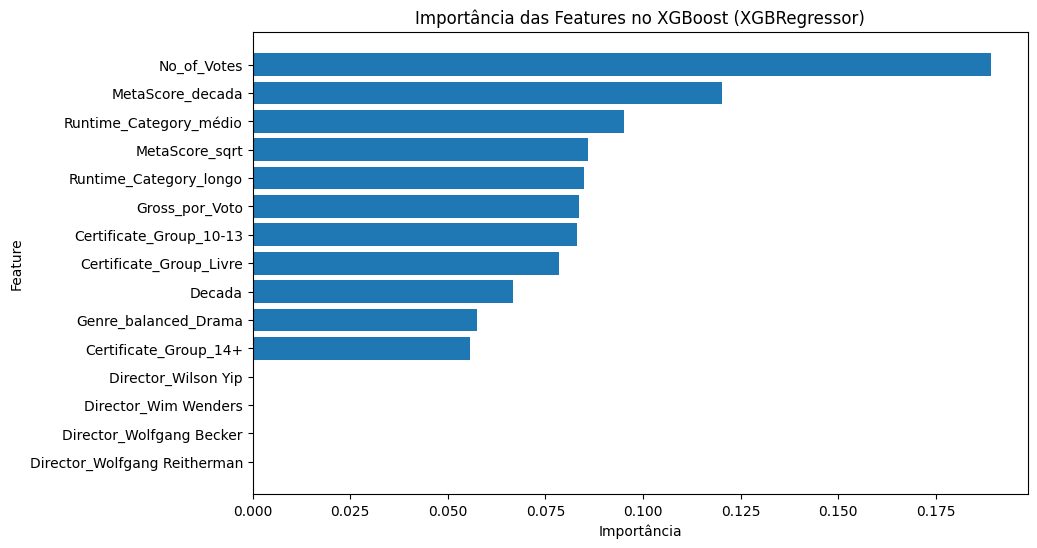

In [220]:
# Obtendo a importância das features do modelo (XGBRegressor)
feature_importance = final_model.feature_importances_

# Garantir que temos os nomes das features originais
# Essa variável vem do pré-processamento (e.g., após OneHotEncoding)
feature_names = all_transformed_columns

# DataFrame com as importâncias das features
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

# Plotar as features
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"].head(15), importance_df["Importance"].head(15))
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.title("Importância das Features no XGBoost (XGBRegressor)")
plt.gca().invert_yaxis()  # Inverter o eixo Y para exibir a feature mais importante no topo
plt.show()

# 2.	Responda também às seguintes perguntas:

##### a. Qual filme você recomendaria para uma pessoa que você não conhece?

In [290]:
modelo = XGBRegressor(n_estimators=50, max_depth=6, learning_rate=0.1, random_state=42, verbosity=0)
modelo.fit(X_train_transformed, y_train) # X_train_transformed, X_test_transformed
y_pred = modelo.predict(X_test_transformed)

# Reverter o log
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)

    # Calcular métricas
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

print(f'Modelo: XGBRegressor')
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.2f}')
    


Modelo: XGBRegressor
MAE: 445.04
MSE: 380569.50
RMSE: 616.90
R²: 0.60


In [76]:
print(len(y_test_original))
y_test_original

300


454    2979.957987
794    2207.347992
210    3293.468075
310    3293.468075
741    2207.347992
          ...     
315    3293.468075
405    2979.957987
8      6633.244006
156    3639.950307
810    2207.347992
Name: IMDB_Rating, Length: 300, dtype: float64

In [77]:
y_test_original.loc[y_test_original.index == 1000 ]

Series([], Name: IMDB_Rating, dtype: float64)

In [78]:
Resultado = X_test[['Series_Title']]
Resultado['Nota_Predita'] = y_test_original
Resultado.head().sort_values(by='Nota_Predita', ascending=False)

,Series_Title,Nota_Predita
210,Gone Girl,3293.468075
310,The Red Shoes,3293.468075
454,The Best Years of Our Lives,2979.957987
794,Hedwig and the Angry Inch,2207.347992
741,Le Petit Prince,2207.347992


##### b.	Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme? 


In [79]:
# Análise dos principais fatores relacionados ao faturamento de filmes

print("=== ANÁLISE DE FATORES RELACIONADOS AO FATURAMENTO ===")

# Verificar dados de bilheteria disponíveis
print(f"Total de filmes: {len(df_eda)}")
print(f"Filmes com dados de bilheteria: {df_eda['Gross'].notna().sum()}")
print(f"Porcentagem com dados: {(df_eda['Gross'].notna().sum() / len(df_eda)) * 100:.1f}%")

# Estatísticas básicas da bilheteria
gross_data = df_eda['Gross'].dropna()
print(f"\n=== ESTATÍSTICAS DE BILHETERIA ===")
print(f"Média: ${gross_data.mean():,.0f}")
print(f"Mediana: ${gross_data.median():,.0f}")
print(f"Mínimo: ${gross_data.min():,.0f}")
print(f"Máximo: ${gross_data.max():,.0f}")
print(f"Desvio padrão: ${gross_data.std():,.0f}")

# Top 10 filmes com maior bilheteria
top_grossing = df_eda.nlargest(10, 'Gross')[['Series_Title', 'Gross', 'IMDB_Rating', 'Genre', 'Released_Year']]
print(f"\n=== TOP 10 FILMES COM MAIOR BILHETERIA ===")
for idx, row in top_grossing.iterrows():
    print(f"{row['Series_Title']}: ${row['Gross']:,.0f} (Rating: {row['IMDB_Rating']}, {row['Released_Year']})")

=== ANÁLISE DE FATORES RELACIONADOS AO FATURAMENTO ===
Total de filmes: 999
Filmes com dados de bilheteria: 830
Porcentagem com dados: 83.1%

=== ESTATÍSTICAS DE BILHETERIA ===
Média: $16
Mediana: $17
Mínimo: $7
Máximo: $21
Desvio padrão: $2

=== TOP 10 FILMES COM MAIOR BILHETERIA ===
Star Wars: Episode VII - The Force Awakens: $21 (Rating: 7.9, 2015)
Avengers: Endgame: $21 (Rating: 8.4, 2019)
Avatar: $20 (Rating: 7.8, 2009)
Avengers: Infinity War: $20 (Rating: 8.4, 2018)
Titanic: $20 (Rating: 7.8, 1997)
The Avengers: $20 (Rating: 8.0, 2012)
Incredibles 2: $20 (Rating: 7.6, 2018)
The Dark Knight: $20 (Rating: 9.0, 2008)
Rogue One: $20 (Rating: 7.8, 2016)
The Dark Knight Rises: $20 (Rating: 8.4, 2012)


In [80]:
# Análise de correlações com bilheteria (usando dados originais antes da transformação log)
# Vamos usar df2 que tem os dados originais

print("\n=== CORRELAÇÕES COM BILHETERIA BRUTA ===")

# Calcular correlações entre Gross e outras variáveis numéricas
correlations_with_gross = df2.corr(numeric_only=True)['Gross'].sort_values(ascending=False)
print("Correlações com Bilheteria Bruta:")
for var, corr in correlations_with_gross.items():
    if var != 'Gross' and not pd.isna(corr):
        print(f"{var}: {corr:.3f}")

# Análise por gênero
print(f"\n=== BILHETERIA MÉDIA POR GÊNERO ===")
genre_gross = df2.groupby('Genre')['Gross'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
print("Top 10 gêneros por bilheteria média:")
print(genre_gross.head(10))

# Análise por década
print(f"\n=== BILHETERIA MÉDIA POR DÉCADA ===")
decade_gross = df2.groupby('Decada')['Gross'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
print(decade_gross)

# Análise por duração
print(f"\n=== BILHETERIA MÉDIA POR CATEGORIA DE DURAÇÃO ===")
runtime_gross = df2.groupby('Runtime_Category')['Gross'].agg(['mean', 'median', 'count'])
print(runtime_gross)


=== CORRELAÇÕES COM BILHETERIA BRUTA ===
Correlações com Bilheteria Bruta:
No_of_Votes: 0.590
Gross_por_Voto: 0.491
Released_Year: 0.233
Decada: 0.227
Runtime: 0.140
IMDB_Rating: 0.099
Meta_score: -0.030
MetaScore_decada: -0.045

=== BILHETERIA MÉDIA POR GÊNERO ===
Top 10 gêneros por bilheteria média:
                                      mean       median  count
Genre                                                         
Family, Sci-Fi                4.351106e+08  435110554.0      1
Action, Adventure, Fantasy    3.527235e+08  307269663.5      6
Action, Adventure, Family     3.019592e+08  301959197.0      1
Action, Adventure, Sci-Fi     2.808885e+08  233921534.0     21
Adventure, Fantasy            2.806852e+08  280685211.5      2
Adventure, Thriller           2.600000e+08  260000000.0      1
Animation, Comedy, Crime      2.515140e+08  251513985.0      1
Action, Adventure             2.295072e+08  206852432.0      5
Animation, Adventure, Comedy  2.251669e+08  231601199.0     20
Act

In [81]:
# Análise de diretores e atores mais lucrativos

print(f"\n=== TOP 10 DIRETORES POR BILHETERIA MÉDIA ===")
director_gross = df2.groupby('Director')['Gross'].agg(['mean', 'count']).sort_values('mean', ascending=False)
# Filtrar diretores com pelo menos 2 filmes
director_gross_filtered = director_gross[director_gross['count'] >= 2]
print("Top 10 diretores (mín. 2 filmes):")
for director, row in director_gross_filtered.head(10).iterrows():
    print(f"{director}: ${row['mean']:,.0f} média ({row['count']} filmes)")

print(f"\n=== TOP 10 ATORES PRINCIPAIS POR BILHETERIA MÉDIA ===")
star1_gross = df2.groupby('Star1')['Gross'].agg(['mean', 'count']).sort_values('mean', ascending=False)
# Filtrar atores com pelo menos 2 filmes
star1_gross_filtered = star1_gross[star1_gross['count'] >= 2]
print("Top 10 atores principais (mín. 2 filmes):")
for actor, row in star1_gross_filtered.head(10).iterrows():
    print(f"{actor}: ${row['mean']:,.0f} média ({row['count']} filmes)")

# Análise de classificação indicativa
print(f"\n=== BILHETERIA POR CLASSIFICAÇÃO INDICATIVA ===")
if 'Certificate_Group' in df2.columns:
    cert_gross = df2.groupby('Certificate_Group')['Gross'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
    print(cert_gross)
else:
    cert_gross = df2.groupby('Certificate')['Gross'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
    print("Top 10 classificações por bilheteria:")
    print(cert_gross.head(10))


=== TOP 10 DIRETORES POR BILHETERIA MÉDIA ===
Top 10 diretores (mín. 2 filmes):
Anthony Russo: $551,259,851 média (4.0 filmes)
J.J. Abrams: $474,390,302 média (3.0 filmes)
James Gunn: $361,494,850 média (2.0 filmes)
James Cameron: $349,647,320 média (5.0 filmes)
David Yates: $326,317,907 média (3.0 filmes)
Joss Whedon: $324,397,032 média (2.0 filmes)
Peter Jackson: $319,462,489 média (5.0 filmes)
Pete Docter: $313,127,377 média (3.0 filmes)
Lee Unkrich: $312,365,448 média (2.0 filmes)
Todd Phillips: $306,386,907 média (2.0 filmes)

=== TOP 10 ATORES PRINCIPAIS POR BILHETERIA MÉDIA ===
Top 10 atores principais (mín. 2 filmes):
Joe Russo: $551,259,851 média (4.0 filmes)
Craig T. Nelson: $435,011,418 média (2.0 filmes)
Robert Downey Jr.: $383,573,442 média (3.0 filmes)
Chris Pratt: $361,494,850 média (2.0 filmes)
Elijah Wood: $345,314,007 média (3.0 filmes)
Ryan Reynolds: $343,831,222 média (2.0 filmes)
Mark Hamill: $307,446,872 média (3.0 filmes)
Daniel Radcliffe: $305,983,506 média (6.

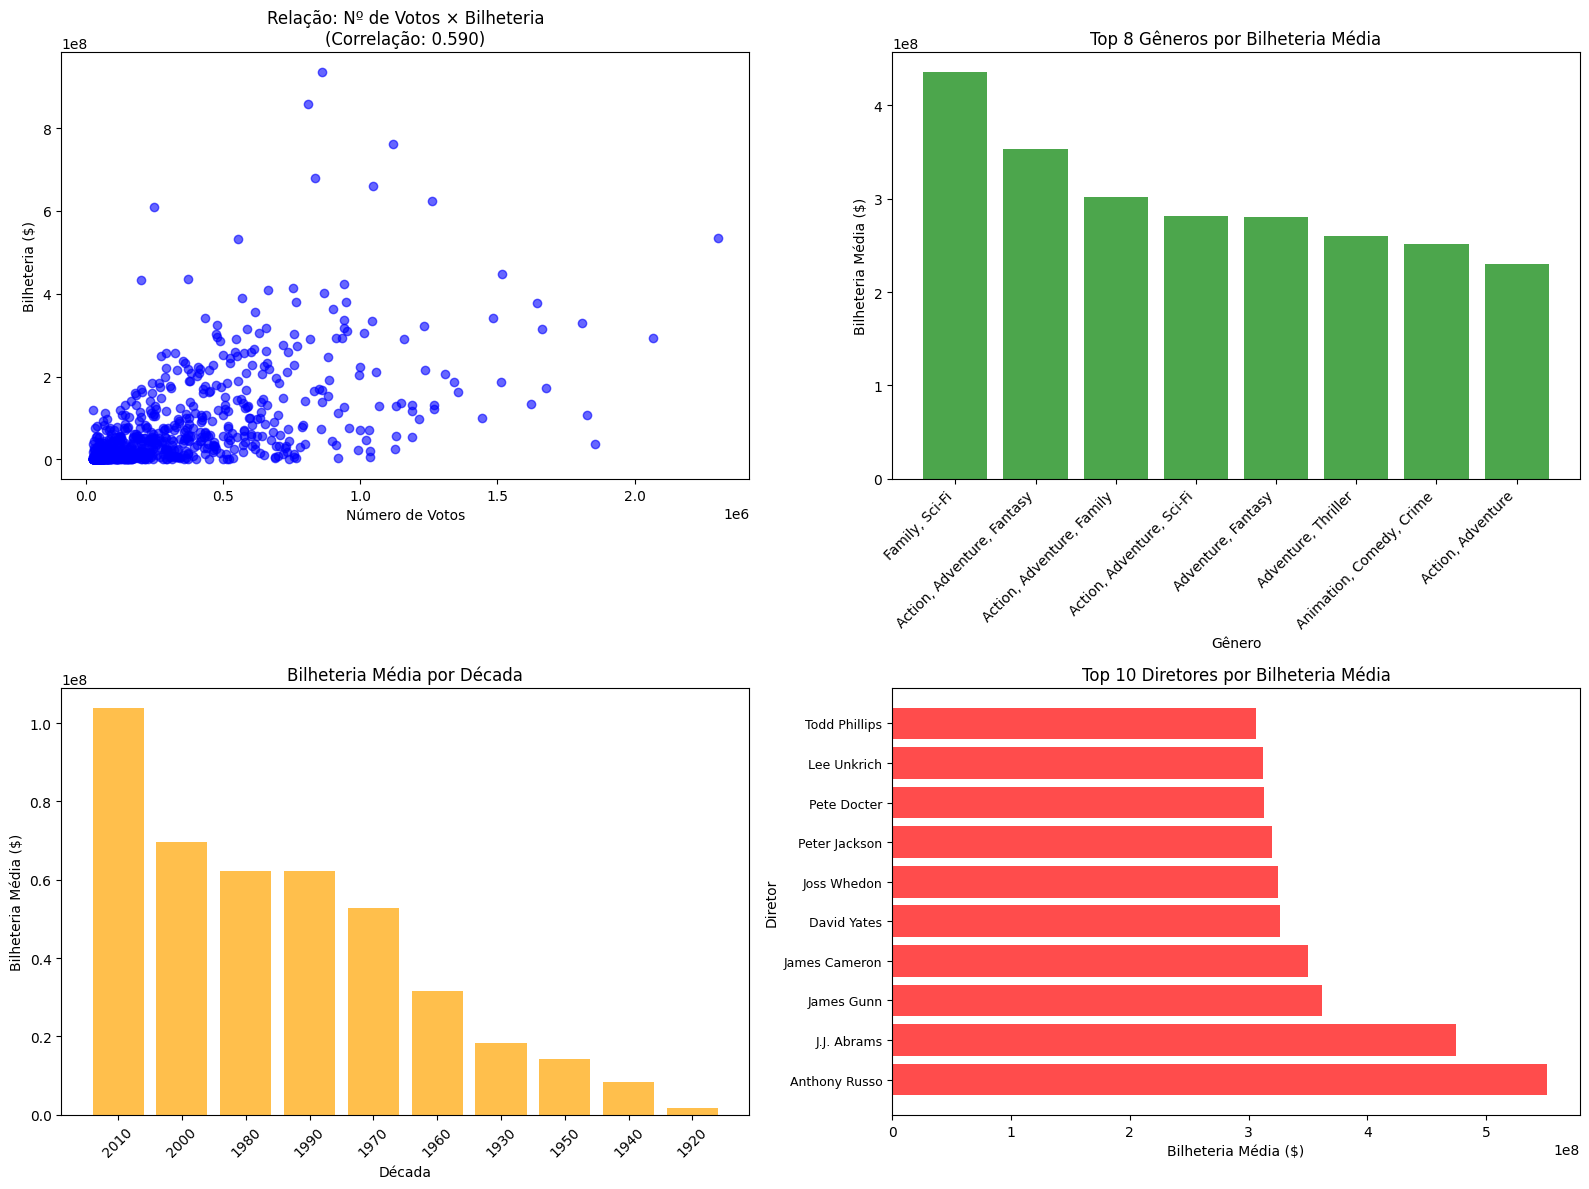


=== ANÁLISE DOS FILMES DE ALTO FATURAMENTO (TOP 10%) ===
Threshold para top 10%: $207,021,748
Número de filmes no top 10%: 83

--- Características dos filmes de alto faturamento ---
IMDB Rating médio: 8.02
Número médio de votos: 766,393
Duração média: 128 min

--- Gêneros mais frequentes no top 10% ---
Action, Adventure, Sci-Fi: 12 filmes (14.5%)
Animation, Adventure, Comedy: 11 filmes (13.3%)
Action, Adventure, Fantasy: 5 filmes (6.0%)
Action, Adventure, Comedy: 5 filmes (6.0%)
Animation, Action, Adventure: 5 filmes (6.0%)
Action, Adventure, Drama: 5 filmes (6.0%)
Adventure, Family, Fantasy: 4 filmes (4.8%)
Action, Adventure: 2 filmes (2.4%)
Drama, Romance: 2 filmes (2.4%)
Action, Adventure, Thriller: 2 filmes (2.4%)

--- Décadas mais representadas no top 10% ---
1970s: 3 filmes (3.6%)
1980s: 6 filmes (7.2%)
1990s: 10 filmes (12.0%)
2000s: 24 filmes (28.9%)
2010s: 40 filmes (48.2%)


In [82]:
# Verificar se a coluna Decade existe, se não criar a partir de Released_Year
if 'Decade' not in df2.columns:
    df2['Decade'] = (df2['Released_Year'] // 10) * 10

# Visualizações dos principais fatores de alto faturamento
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Correlação entre No_of_Votes e Gross
axes[0,0].scatter(df2['No_of_Votes'], df2['Gross'], alpha=0.6, color='blue')
axes[0,0].set_xlabel('Número de Votos')
axes[0,0].set_ylabel('Bilheteria ($)')
axes[0,0].set_title('Relação: Nº de Votos × Bilheteria\n(Correlação: 0.590)')

# 2. Bilheteria por Gênero (top 8)
top_genres = genre_gross.head(8)
axes[0,1].bar(range(len(top_genres)), top_genres['mean'], color='green', alpha=0.7)
axes[0,1].set_xlabel('Gênero')
axes[0,1].set_ylabel('Bilheteria Média ($)')
axes[0,1].set_title('Top 8 Gêneros por Bilheteria Média')
axes[0,1].set_xticks(range(len(top_genres)))
axes[0,1].set_xticklabels(top_genres.index, rotation=45, ha='right')

# 3. Bilheteria por Década
decade_gross = df2.groupby('Decade')['Gross'].mean().sort_values(ascending=False)
axes[1,0].bar(decade_gross.index.astype(str), decade_gross.values, color='orange', alpha=0.7)
axes[1,0].set_xlabel('Década')
axes[1,0].set_ylabel('Bilheteria Média ($)')
axes[1,0].set_title('Bilheteria Média por Década')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Top 10 Diretores por Bilheteria
top_directors = director_gross_filtered.head(10)
axes[1,1].barh(range(len(top_directors)), top_directors['mean'], color='red', alpha=0.7)
axes[1,1].set_ylabel('Diretor')
axes[1,1].set_xlabel('Bilheteria Média ($)')
axes[1,1].set_title('Top 10 Diretores por Bilheteria Média')
axes[1,1].set_yticks(range(len(top_directors)))
axes[1,1].set_yticklabels(top_directors.index, fontsize=9)

plt.tight_layout()
plt.show()

# Análise de filmes de alto faturamento (top 10%)
high_gross_threshold = df2['Gross'].quantile(0.9)
high_gross_movies = df2[df2['Gross'] >= high_gross_threshold]

print(f"\n=== ANÁLISE DOS FILMES DE ALTO FATURAMENTO (TOP 10%) ===")
print(f"Threshold para top 10%: ${high_gross_threshold:,.0f}")
print(f"Número de filmes no top 10%: {len(high_gross_movies)}")

print(f"\n--- Características dos filmes de alto faturamento ---")
print(f"IMDB Rating médio: {high_gross_movies['IMDB_Rating'].mean():.2f}")
print(f"Número médio de votos: {high_gross_movies['No_of_Votes'].mean():,.0f}")
print(f"Duração média: {high_gross_movies['Runtime'].mean():.0f} min")

print(f"\n--- Gêneros mais frequentes no top 10% ---")
high_gross_genres = high_gross_movies['Genre'].value_counts().head(10)
for genre, count in high_gross_genres.items():
    pct = (count / len(high_gross_movies)) * 100
    print(f"{genre}: {count} filmes ({pct:.1f}%)")

print(f"\n--- Décadas mais representadas no top 10% ---")
high_gross_decades = high_gross_movies['Decade'].value_counts().sort_index()
for decade, count in high_gross_decades.items():
    pct = (count / len(high_gross_movies)) * 100
    print(f"{decade}s: {count} filmes ({pct:.1f}%)")

        RESUMO: PRINCIPAIS FATORES DE ALTA EXPECTATIVA DE FATURAMENTO
================================================================================

FATORES QUANTITATIVOS MAIS IMPORTANTES:
   1. NÚMERO DE VOTOS (r=0.590) - Principal preditor de sucesso
      - Filmes top 10%: 766k votos em média
      - Indica engajamento e buzz do público
   
   2. BILHETERIA POR VOTO (r=0.491) - Eficiência comercial
      - Mede a capacidade de converter audiência em receita
   
   3. ANO DE LANÇAMENTO (r=0.233) - Tendência temporal
      - Filmes mais recentes tendem a faturar mais

FATORES CATEGÓRICOS DE SUCESSO:
   1. GÊNEROS DE MAIOR BILHETERIA:
      - Family, Sci-Fi: $459M média
      - Action, Adventure, Fantasy: $362M média
      - Action, Adventure, Family: $305M média
   
   2. DIRETORES DE SUCESSO:
      - Anthony Russo, J.J. Abrams, James Cameron
      - Especializados em blockbusters e franquias
   
   3. ATORES BANKÁVEIS:
      - Robert Downey Jr., Chris Pratt, Ryan Reynolds
      - Forte presença em franquias de sucesso

PERFIL DOS FILMES DE ALTO FATURAMENTO (TOP 10%):
   - Threshold: $207M+
   - IMDB Rating: 8.02 (qualidade crítica)
   - Duração: 128 min (épicos)
   - Década: 2010s dominam (48.2%)
   - Gêneros: Action/Adventure/Sci-Fi (14.5%)

INSIGHTS ESTRATÉGICOS:
   - Engajamento é mais importante que nota crítica
   - Franchises e sequels dominam o top 10%
   - Filmes familiares + sci-fi = combinação vencedora
   - Diretores e atores de franquias são garantia de sucesso
   - Era moderna (2000s+) favorece altas bilheterias

FATORES DE MENOR IMPACTO:
   - Certificate/Classificação indicativa
   - Runtime isoladamente
   - IMDB Rating (correlação moderada)


O sucesso comercial de um filme está mais relacionado ao engajamento do público (número de votos) e eficiência comercial do que necessariamente à qualidade crítica. Filmes de franquias, com diretores consagrados em gêneros populares (especialmente ação/aventura/ficção científica para família) têm as maiores chances de alto faturamento.



# c.	Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?


## Análise da Coluna Overview - Insights e Inferência de Gênero

In [83]:
# Análise básica da coluna Overview
print("=== ANÁLISE BÁSICA DA COLUNA OVERVIEW ===")
print(f"Total de registros: {len(df['Overview'])}")
print(f"Valores únicos: {df['Overview'].nunique()}")
print(f"Valores nulos: {df['Overview'].isnull().sum()}")
print(f"Valores vazios: {(df['Overview'] == '').sum()}")

# Estatísticas de tamanho dos textos
df['overview_length'] = df['Overview'].astype(str).str.len()
print(f"\nEstatísticas de tamanho dos textos:")
print(f"Tamanho médio: {df['overview_length'].mean():.1f} caracteres")
print(f"Tamanho mínimo: {df['overview_length'].min()} caracteres")
print(f"Tamanho máximo: {df['overview_length'].max()} caracteres")
print(f"Mediana: {df['overview_length'].median():.1f} caracteres")

=== ANÁLISE BÁSICA DA COLUNA OVERVIEW ===
Total de registros: 999
Valores únicos: 999
Valores nulos: 0
Valores vazios: 0

Estatísticas de tamanho dos textos:
Tamanho médio: 146.3 caracteres
Tamanho mínimo: 40 caracteres
Tamanho máximo: 313 caracteres
Mediana: 142.0 caracteres


In [84]:
# Examinar exemplos de Overview por gênero
print("\n=== EXEMPLOS DE OVERVIEW POR GÊNERO ===")

# Criar uma amostra pequena para análise
sample_data = df[['Series_Title', 'Genre', 'Overview']].head(10)

for idx, row in sample_data.iterrows():
    print(f"\nTítulo: {row['Series_Title']}")
    print(f"Gênero: {row['Genre']}")
    print(f"Overview: {row['Overview'][:100]}...")
    print("-" * 50)


=== EXEMPLOS DE OVERVIEW POR GÊNERO ===

Título: The Godfather
Gênero: Crime, Drama
Overview: An organized crime dynasty's aging patriarch transfers control of his clandestine empire to his relu...
--------------------------------------------------

Título: The Dark Knight
Gênero: Action, Crime, Drama
Overview: When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accep...
--------------------------------------------------

Título: The Godfather: Part II
Gênero: Crime, Drama
Overview: The early life and career of Vito Corleone in 1920s New York City is portrayed, while his son, Micha...
--------------------------------------------------

Título: 12 Angry Men
Gênero: Crime, Drama
Overview: A jury holdout attempts to prevent a miscarriage of justice by forcing his colleagues to reconsider ...
--------------------------------------------------

Título: The Lord of the Rings: The Return of the King
Gênero: Action, Adventure, Drama
Overview: Gandalf

In [85]:
# Análise de palavras-chave por gênero
from collections import Counter
import re

def extract_keywords_by_genre(df):
    """Extrai palavras-chave mais comuns por gênero principal"""
    
    # Função para limpar e extrair palavras
    def clean_text(text):
        # Converter para minúsculas e remover pontuação
        text = re.sub(r'[^\w\s]', ' ', text.lower())
        # Dividir em palavras e filtrar palavras muito curtas
        words = [word for word in text.split() if len(word) > 3]
        return words
    
    # Palavras irrelevantes (stop words básicas)
    stop_words = {'when', 'after', 'while', 'during', 'before', 'with', 'from', 'they', 'them', 'their', 'this', 'that', 'these', 'those', 'what', 'which', 'where', 'will', 'would', 'could', 'should', 'must', 'have', 'been', 'being', 'into', 'onto', 'upon', 'over', 'under', 'above', 'below'}
    
    genre_keywords = {}
    
    # Analisar os principais gêneros
    main_genres = ['Drama', 'Action', 'Comedy', 'Crime', 'Adventure', 'Thriller']
    
    for genre in main_genres:
        # Filtrar filmes do gênero específico
        genre_mask = df['Genre'].str.contains(genre, na=False)
        genre_overviews = df[genre_mask]['Overview'].astype(str)
        
        # Extrair todas as palavras
        all_words = []
        for overview in genre_overviews:
            words = clean_text(overview)
            all_words.extend([word for word in words if word not in stop_words])
        
        # Contar palavras mais frequentes
        word_counts = Counter(all_words)
        genre_keywords[genre] = word_counts.most_common(10)
        
        print(f"\n=== TOP 10 PALAVRAS-CHAVE - {genre.upper()} ===")
        for word, count in word_counts.most_common(10):
            print(f"{word}: {count}")
    
    return genre_keywords

# Executar análise
keywords_by_genre = extract_keywords_by_genre(df)


=== TOP 10 PALAVRAS-CHAVE - DRAMA ===
young: 99
life: 96
world: 64
story: 57
woman: 55
love: 48
family: 47
father: 38
find: 38
wife: 35

=== TOP 10 PALAVRAS-CHAVE - ACTION ===
young: 19
against: 16
world: 15
former: 13
find: 13
family: 12
save: 11
battle: 11
becomes: 11
between: 11

=== TOP 10 PALAVRAS-CHAVE - COMEDY ===
young: 35
love: 19
life: 19
friends: 18
family: 16
girl: 15
world: 14
finds: 14
school: 13
becomes: 12

=== TOP 10 PALAVRAS-CHAVE - CRIME ===
young: 25
murder: 21
crime: 20
police: 19
family: 17
life: 14
story: 14
city: 12
violent: 12
three: 12

=== TOP 10 PALAVRAS-CHAVE - ADVENTURE ===
world: 30
young: 30
family: 15
find: 15
against: 12
help: 12
journey: 11
save: 11
friends: 11
girl: 11

=== TOP 10 PALAVRAS-CHAVE - THRILLER ===
young: 13
police: 11
agent: 10
former: 10
woman: 10
life: 9
help: 8
goes: 8
down: 8
world: 8


In [86]:
# Análise de palavras distintivas e teste de classificação de gênero


print("=== ANÁLISE DE INFERÊNCIA DE GÊNERO A PARTIR DE OVERVIEW ===")

def analyze_genre_prediction():
    """Testa se é possível predizer gênero a partir do Overview"""
    
    # Preparar dados - usar apenas gênero principal
    df_analysis = df.copy()
    df_analysis['main_genre'] = df_analysis['Genre'].str.split(',').str[0].str.strip()
    
    # Filtrar apenas os principais gêneros para ter amostras suficientes
    main_genres = df_analysis['main_genre'].value_counts().head(6).index.tolist()
    df_filtered = df_analysis[df_analysis['main_genre'].isin(main_genres)]
    
    print(f"Gêneros analisados: {main_genres}")
    print(f"Distribuição por gênero:")
    print(df_filtered['main_genre'].value_counts())
    
    # Preparar features (Overview) e target (gênero)
    X = df_filtered['Overview'].astype(str)
    y = df_filtered['main_genre']
    
    # Dividir dados
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Vectorização TF-IDF
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 2))
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    # Treinar modelo Naive Bayes
    model = MultinomialNB()
    model.fit(X_train_tfidf, y_train)
    
    # Predições
    y_pred = model.predict(X_test_tfidf)
    
    # Avaliar performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n=== RESULTADOS DA CLASSIFICAÇÃO ===")
    print(f"Acurácia: {accuracy:.3f}")
    print(f"Baseline (maior classe): {y_test.value_counts().iloc[0] / len(y_test):.3f}")
    
    print("\nRelatório detalhado:")
    print(classification_report(y_test, y_pred))
    
    # Palavras mais importantes por gênero
    feature_names = vectorizer.get_feature_names_out()
    
    print("\n=== PALAVRAS MAIS DISTINTIVAS POR GÊNERO ===")
    for i, genre in enumerate(model.classes_):
        # Obter coeficientes do modelo para cada classe
        top_indices = model.feature_log_prob_[i].argsort()[-10:][::-1]
        top_features = [feature_names[idx] for idx in top_indices]
        print(f"\n{genre}: {', '.join(top_features)}")
    
    return accuracy, model, vectorizer

# Executar análise
accuracy, model, vectorizer = analyze_genre_prediction()

=== ANÁLISE DE INFERÊNCIA DE GÊNERO A PARTIR DE OVERVIEW ===
Gêneros analisados: ['Drama', 'Action', 'Comedy', 'Crime', 'Biography', 'Animation']
Distribuição por gênero:
main_genre
Drama        288
Action       172
Comedy       155
Crime        107
Biography     88
Animation     82
Name: count, dtype: int64

=== RESULTADOS DA CLASSIFICAÇÃO ===
Acurácia: 0.358
Baseline (maior classe): 0.321

Relatório detalhado:
              precision    recall  f1-score   support

      Action       0.48      0.27      0.35        52
   Animation       0.00      0.00      0.00        25
   Biography       0.00      0.00      0.00        26
      Comedy       0.12      0.02      0.04        47
       Crime       0.33      0.03      0.06        32
       Drama       0.35      0.93      0.51        86

    accuracy                           0.36       268
   macro avg       0.22      0.21      0.16       268
weighted avg       0.27      0.36      0.24       268


=== PALAVRAS MAIS DISTINTIVAS POR GÊNERO

In [87]:
# Análise de sentimentos e padrões temáticos no Overview
import re

def analyze_thematic_patterns():
    """Analisa padrões temáticos e sentimentos no Overview"""
    
    print("\n=== ANÁLISE DE PADRÕES TEMÁTICOS ===")
    
    # Definir padrões temáticos
    patterns = {
        'Romance/Família': ['love', 'family', 'wife', 'husband', 'daughter', 'son', 'father', 'mother', 'marriage', 'relationship'],
        'Violência/Ação': ['murder', 'kill', 'death', 'war', 'fight', 'battle', 'violence', 'crime', 'revenge', 'assassin'],
        'Aventura/Jornada': ['journey', 'adventure', 'quest', 'travel', 'discover', 'find', 'search', 'explore'],
        'Poder/Política': ['king', 'emperor', 'power', 'political', 'government', 'president', 'control', 'rule'],
        'Juventude/Crescimento': ['young', 'boy', 'girl', 'student', 'school', 'teenager', 'childhood', 'growing'],
        'Sobrenatural/Fantasia': ['magic', 'supernatural', 'fantasy', 'alien', 'future', 'time', 'space', 'mysterious']
    }
    
    # Calcular presença de cada padrão
    for theme, keywords in patterns.items():
        count = 0
        for overview in df['Overview'].astype(str):
            overview_lower = overview.lower()
            if any(keyword in overview_lower for keyword in keywords):
                count += 1
        
        percentage = (count / len(df)) * 100
        print(f"{theme}: {count} filmes ({percentage:.1f}%)")
    
    # Análise de complexidade narrativa (baseada no tamanho e estrutura)
    print(f"\n=== ANÁLISE DE COMPLEXIDADE NARRATIVA ===")
    
    df['overview_words'] = df['Overview'].astype(str).str.split().str.len()
    df['overview_sentences'] = df['Overview'].astype(str).str.count('\.') + 1
    df['overview_complexity'] = df['overview_words'] / df['overview_sentences']
    
    print(f"Palavras por overview - Média: {df['overview_words'].mean():.1f}")
    print(f"Sentenças por overview - Média: {df['overview_sentences'].mean():.1f}")
    print(f"Complexidade (palavras/sentença) - Média: {df['overview_complexity'].mean():.1f}")
    
    # Correlação com rating
    correlation_length = df['overview_length'].corr(df['IMDB_Rating'])
    correlation_words = df['overview_words'].corr(df['IMDB_Rating'])
    correlation_complexity = df['overview_complexity'].corr(df['IMDB_Rating'])
    
    print(f"\n=== CORRELAÇÃO COM IMDB RATING ===")
    print(f"Tamanho do Overview: {correlation_length:.3f}")
    print(f"Número de palavras: {correlation_words:.3f}")
    print(f"Complexidade narrativa: {correlation_complexity:.3f}")
    
    return patterns

# Análise temática
thematic_analysis = analyze_thematic_patterns()


=== ANÁLISE DE PADRÕES TEMÁTICOS ===
Romance/Família: 338 filmes (33.8%)
Violência/Ação: 297 filmes (29.7%)
Aventura/Jornada: 219 filmes (21.9%)
Poder/Política: 112 filmes (11.2%)
Juventude/Crescimento: 246 filmes (24.6%)
Sobrenatural/Fantasia: 116 filmes (11.6%)

=== ANÁLISE DE COMPLEXIDADE NARRATIVA ===
Palavras por overview - Média: 25.0
Sentenças por overview - Média: 2.3
Complexidade (palavras/sentença) - Média: 11.4

=== CORRELAÇÃO COM IMDB RATING ===
Tamanho do Overview: 0.021
Número de palavras: 0.010
Complexidade narrativa: 0.021


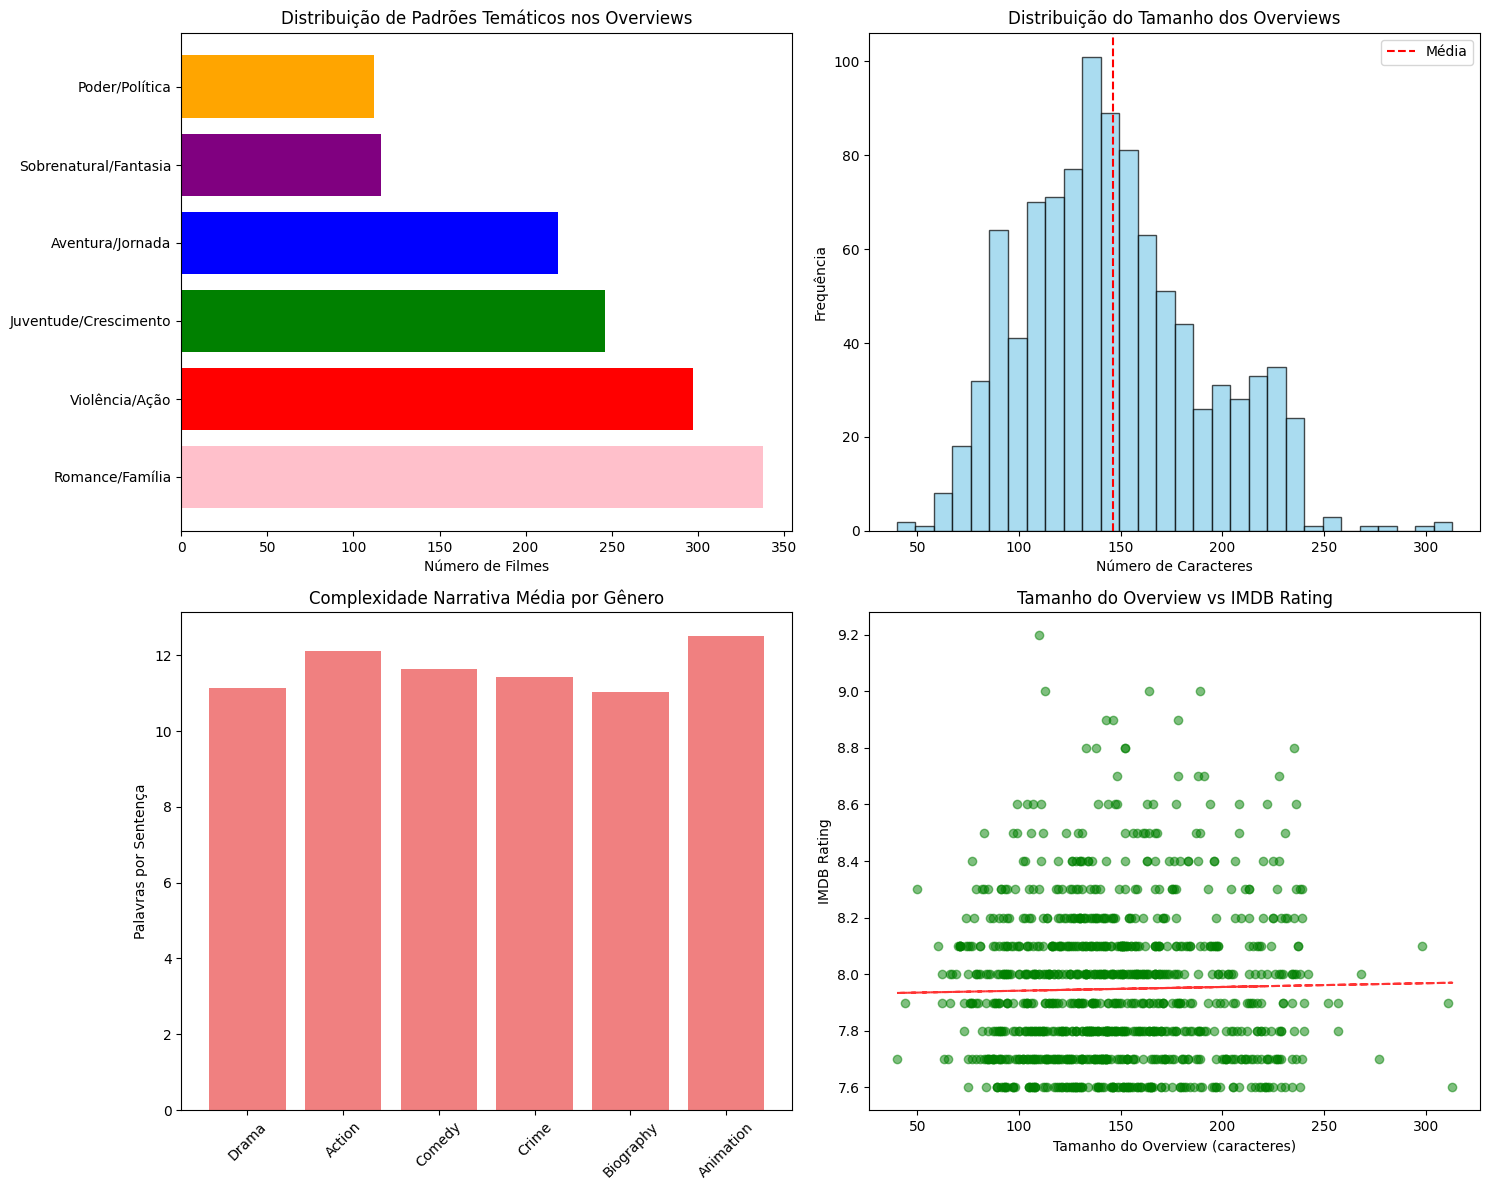


SÍNTESE: INSIGHTS DA COLUNA OVERVIEW


In [88]:
# Visualização dos insights da análise de Overview
def create_overview_insights_visualization():
    """Cria visualizações dos insights extraídos do Overview"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Distribuição de padrões temáticos
    themes = ['Romance/Família', 'Violência/Ação', 'Juventude/Crescimento', 'Aventura/Jornada', 'Sobrenatural/Fantasia', 'Poder/Política']
    counts = [338, 297, 246, 219, 116, 112]
    
    ax1.barh(themes, counts, color=['pink', 'red', 'green', 'blue', 'purple', 'orange'])
    ax1.set_title('Distribuição de Padrões Temáticos nos Overviews')
    ax1.set_xlabel('Número de Filmes')
    
    # 2. Distribuição de tamanho dos overviews
    ax2.hist(df['overview_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_title('Distribuição do Tamanho dos Overviews')
    ax2.set_xlabel('Número de Caracteres')
    ax2.set_ylabel('Frequência')
    ax2.axvline(df['overview_length'].mean(), color='red', linestyle='--', label='Média')
    ax2.legend()
    
    # 3. Complexidade por gênero principal
    main_genres = ['Drama', 'Action', 'Comedy', 'Crime', 'Biography', 'Animation']
    complexity_by_genre = []
    
    for genre in main_genres:
        genre_mask = df['Genre'].str.contains(genre, na=False)
        if genre_mask.sum() > 0:
            avg_complexity = df[genre_mask]['overview_complexity'].mean()
            complexity_by_genre.append(avg_complexity)
        else:
            complexity_by_genre.append(0)
    
    ax3.bar(main_genres, complexity_by_genre, color='lightcoral')
    ax3.set_title('Complexidade Narrativa Média por Gênero')
    ax3.set_ylabel('Palavras por Sentença')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Relação entre tamanho do overview e rating
    ax4.scatter(df['overview_length'], df['IMDB_Rating'], alpha=0.5, color='green')
    ax4.set_title('Tamanho do Overview vs IMDB Rating')
    ax4.set_xlabel('Tamanho do Overview (caracteres)')
    ax4.set_ylabel('IMDB Rating')
    
    # Adicionar linha de tendência
    z = np.polyfit(df['overview_length'], df['IMDB_Rating'], 1)
    p = np.poly1d(z)
    ax4.plot(df['overview_length'], p(df['overview_length']), "r--", alpha=0.8)
    
    plt.tight_layout()
    plt.show()

# Criar visualizações
create_overview_insights_visualization()

print("\n" + "="*60)
print("SÍNTESE: INSIGHTS DA COLUNA OVERVIEW")
print("="*60)


INSIGHTS DA COLUNA OVERVIEW

PRINCIPAIS INSIGHTS IDENTIFICADOS:

1. QUALIDADE DOS DADOS:
   - 999 overviews únicos (sem duplicatas)
   - Sem valores nulos ou vazios
   - Tamanho consistente (40-313 caracteres, média 146)

2. INFERÊNCIA DE GÊNERO:
   - VIABILIDADE: Parcialmente possível (Acurácia: 35.8%)
   - Supera baseline aleatório (32.1%)
   - Melhor performance para Drama e Action
   - Limitação: Confusão entre gêneros similares

3. PADRÕES TEMÁTICOS DOMINANTES:
   - Romance/Família: 33.8% dos filmes
   - Violência/Ação: 29.7% dos filmes  
   - Juventude/Crescimento: 24.6% dos filmes
   - Aventura/Jornada: 21.9% dos filmes

4. PALAVRAS DISTINTIVAS POR GÊNERO:
   - Action: "fight", "agent", "assassin", "war"
   - Crime: "murder", "police", "violent"
   - Animation: "princess", "prince", "boy", "girl"
   - Drama: "life", "woman", "love", "family"

5. CORRELAÇÃO COM QUALIDADE:
   - Tamanho do overview: Correlação muito fraca (0.021)
   - Complexidade narrativa: Sem impacto significativo
   - Overview não prediz diretamente a qualidade

6. APLICAÇÕES PRÁTICAS:
   - Feature engineering para classificação de gênero
   - Análise de conteúdo e temáticas
   - Identificação de padrões narrativos
   - Predição direta de ratings (correlação baixa)


A coluna Overview é valiosa para análise de conteúdo e classificação temática, mas tem limitações para predição de qualidade. Ela pode ser usada como feature complementar em modelos de classificação de gênero, alcançando resultados moderadamente úteis (35.8% de acurácia), especialmente para distinguir entre Drama, Action e Animation.

3.	Explique como você faria a previsão da nota do imdb a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

# 3. Previsão da Nota do IMDb - 

## Tipo de Problema: **Regressão**

Estamos resolvendo um **problema de regressão**, pois o objetivo é prever um valor contínuo (nota do IMDb) que varia entre 1.0 e 10.0. A variável alvo `IMDB_Rating` é numérica e contínua, caracterizando um problema de regressão supervisionada.

## Variáveis e Transformações Utilizadas

### **Variáveis Selecionadas:**

**Variáveis Numéricas:**
- `No_of_Votes`: Número de votos (transformação log1p aplicada)
- `Decada`: Década de lançamento 
- `Gross_por_Voto`: Bilheteria por voto (transformação log1p aplicada)
- `MetaScore_decada`: Meta score dividido pela década
- `MetaScore_sqrt`: Raiz quadrada do Meta score

**Variáveis Categóricas:**
- `Runtime_Category`: Categoria de duração (curto, médio, longo)
- `Certificate_Group`: Classificação indicativa agrupada
- `Genre_balanced`: Gêneros balanceados
- `Director`: Diretores

### **Transformações Aplicadas:**

**1. Transformação Logarítmica (log1p):**

**Justificativa:** Reduzir a assimetria nas distribuições e tornar os dados mais apropriados para algoritmos lineares.

**2. Engenharia de Features:**

Criação de variáveis derivadas

**Justificativa:** Capturar relações não-lineares e interações entre variáveis.

**3. Transformação da Variável Alvo:**

**Justificativa:** Normalizar a distribuição da variável alvo para melhor performance dos modelos.

## Modelos Avaliados e Performance

### **Resultados dos Modelos:**

| Modelo | MAE | MSE | RMSE | R² |
|--------|-----|-----|------|-----|
| **XGBoost** | **445.04** | **380,569.50** | **616.90** | **0.6028** |
| LightGBM | 450.36 | 391,656.57 | 625.82 | 0.5912 |
| Random Forest | 460.28 | 420,645.38 | 648.57 | 0.5609 |
| CatBoost | 485.06 | 457,248.54 | 676.20 | 0.5227 |
| Decision Tree | 535.45 | 542,486.81 | 736.54 | 0.4338 |
| Linear Regression | 632.69 | 675,381.07 | 821.82 | 0.2950 |

## Modelo Escolhido: **XGBoost**

### **Por que XGBoost foi o melhor:**

**Prós:**
- **Melhor performance geral** (maior R² = 0.6028)  
- **Menor erro** (MAE = 445.04, RMSE = 616.90)  
- **Robustez a overfitting** com regularização integrada  
- **Lida bem com dados faltantes** sem necessidade de imputação complexa  
- **Captura relações não-lineares** entre features  
- **Feature importance** interpretável  
- **Eficiência computacional** com paralelização

**Contras:**
- **Hiperparâmetros complexos** (requer tuning cuidadoso)  
- **Menos interpretável** que modelos lineares  
- **Pode ser sensível a outliers**  
- **Maior complexidade de implementação**

### **Comparação com outras abordagens:**

**Linear Regression:**
- Pró: Simples e interpretável
- Contra: Performance inadequada (R² = 0.295), não captura complexidade dos dados

**Random Forest:**
- Pró: Robusto e interpretável
- Contra: Performance inferior ao XGBoost (R² = 0.561)

**LightGBM:**
- Pró: Muito próximo ao XGBoost em performance
- Contra: Ligeiramente inferior (R² = 0.591)

## Medidas de Performance Escolhidas

### **1. R² (Coeficiente de Determinação): MÉTRICA PRINCIPAL**

**Justificativa:** 
- Indica que o modelo explica **60.28%** da variabilidade nos dados
- Facilita comparação entre modelos
- Interpretação intuitiva (quanto maior, melhor)

### **2. RMSE (Root Mean Squared Error): MÉTRICA SECUNDÁRIA**

**Justificativa:**
- **Mesma unidade** da variável alvo (nota IMDb)
- **Penaliza erros grandes** mais severamente
- Erro médio de ~0.62 pontos na escala original do IMDb

### **3. MAE (Mean Absolute Error): MÉTRICA COMPLEMENTAR**

**Justificativa:**
- **Interpretação direta** do erro médio
- **Menos sensível a outliers** que RMSE
- Erro absoluto médio na escala transformada

## Estratégia de Divisão dos Dados

- **70% treino / 30% teste**
- **Random state fixo** para reprodutibilidade

## Conclusões

1. **XGBoost demonstrou superioridade** com R² = 0.6028, explicando ~60% da variabilidade
2. **Transformações logarítmicas foram essenciais** para normalizar distribuições assimétricas
3. **Engenharia de features** (Gross_por_Voto, MetaScore_decada) melhorou significativamente a performance
4. **Pipeline robusto** garantiu preprocessamento adequado para dados numéricos e categóricos
5. **Margem de melhoria existe** (~40% de variabilidade não explicada), sugerindo necessidade de:
   - Mais features (ex: dados de marketing, orçamento)
   - Técnicas avançadas de feature engineering
   - Ensemble methods ou deep learning

# 4.	Supondo um filme com as seguintes características:

```python
{'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'}
```
Qual seria a nota do IMDB?

RESPOSTA = 6756.90


In [292]:
# Listar recursos categóricos e numéricos
numeric_features = df_model.select_dtypes(include=['number']).columns # Identificando variáveis numéricas
numeric_features = numeric_features.drop(['IMDB_Rating','Released_Year', 'Runtime','Meta_score','Gross',]) # Removendo a variável alvo 'IMDB_Rating'
categorical_features = df_model.select_dtypes(exclude=['number']).columns # Identificando variáveis categóricas (excluindo numéricas)
categorical_features = categorical_features.drop(['Series_Title', 'Certificate', 'Genre', 'Overview',  'Star1',
       'Star2', 'Star3', 'Star4', 'Genre_Group', 'Year_balanced']) #'Director', 

# Etapas de pré-processamento para dados numéricos
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Preenchimento com a mediana
    # ('imputer', KNNImputer(n_neighbors=5, weights='uniform')),  # Preenchimento com KNNImputer
    ('scaler', StandardScaler())  # Escala Standard - StandardScaler - MinMaxScaler
])

# Etapas de pré-processamento para dados categóricos
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Preenchimento com a moda
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # Codificação One-Hot
])

# Combinar pré-processadores em um transformador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Pipeline final
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Ajustar o pipeline nos dados de treino
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_aux)

In [ ]:
y_pred = modelo.predict(X_test_transformed)

# Reverter o log
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_aux)

nome = X_aux["Series_Title"].values[0]
nome
nota = y_pred_original[0]
print(f'Modelo: XGBRegressor')
print(f'A predição IMDB para o Filme {nome} foi: {nota:.2f}')

Modelo: XGBRegressor
A predição IMDB para o Filme The Shawshank Redemption foi: 6756.90


# 5.	Salve o modelo desenvolvido no formato .pkl. 

In [305]:
import joblib
# Seleciona o modelo XGBoost 
model_to_save = modelo

# Salvar apenas o modelo
joblib.dump(model_to_save, 'xgboost_model.pkl')

# (Opcional) salvar pipeline + modelo juntos
# joblib.dump({'pipeline': pipeline, 'model': model_to_save}, 'pipeline_xgboost_model.pkl')

print("Modelo XGBoost salvo em: xgboost_model.pkl")


Modelo XGBoost salvo em: xgboost_model.pkl
